# Análise de evidências de fraude nas urnas.

Recentemente tomei conhecimento de uma discussão sobre "urnas fraudadas" devido aos diversos casos de urnas estatisticamente absurdas.

144 urnas possuem 100% de votos para o Lula, enquanto apenas 5 urnas possuem 100% de votos para o Bolsonaro, algo estatisticamente improvável em caso de amostras aleatórias. No entanto, as urnas possuem o viés de localização, pois apenas pessoas que moram em sua zona eleitoral podem votar nessas seções.

Existe também o viés do perfil do eleitor do Bolsonaro e do Lula.

Nesta análise, verificaremos evidências de fraudes nas urnas, baseado em suas zonas eleitorais, perfil dos eleitores e endereços de votação.

Os dados para análise podem ser obtidos no site do TSE

link: https://dadosabertos.tse.jus.br/dataset/resultados-2022-boletim-de-urna

# 1 - Preparo de dados e bibliotecas

## 1.1 Funções e bibliotecas

In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.stats import norm, binom

In [2]:
def media_de_votos(df,uf=None, zona = None,  secao = None, municipio = None, local = None):
    df_set = df
    
    if uf:
        df_set = df_set[df_set.SG_UF == uf]
    if municipio:
        df_set = df_set[df_set.NM_MUNICIPIO == municipio]
    if zona:
        df_set = df_set[df_set.NR_ZONA == zona]
    if local:
        df_set = df_set[df_set.DS_LOCAL_VOTACAO_ENDERECO == local]
    if secao:
        df_set = df_set[df_set.NR_SECAO == secao]
    return df_set.BOLSONARO.sum()/df_set.total.sum()

In [99]:
from matplotlib.ticker import PercentFormatter
import seaborn as sns
plt.rcParams['figure.figsize'] = [11, 7]
sns.set()

def plot_regiao(df,uf=None, zona = None,  secao = None, municipio = None, local = None, normal=False, title = None):
    df_set = df.copy()
    if uf:
        df_set = df_set[df_set.SG_UF == uf]
    if municipio:
        df_set = df_set[df_set.NM_MUNICIPIO == municipio]
    if zona:
        df_set = df_set[df_set.NR_ZONA == zona]
    if local:
        df_set = df_set[df_set.DS_LOCAL_VOTACAO_ENDERECO == local]
    if secao:
        df_set = df_set[df_set.NR_SECAO == secao]
    
    fig, ax = plt.subplots()
    values, bins, _ = plt.hist(df_set.porcentagem, bins = 50, range=[0,1])
    
    if normal:
        area = sum(np.diff(bins)*values)
        mu, std = norm.fit(df_set.porcentagem)
        x = np.linspace(mu - 4*std, mu + 4*std, 100)
        x = x[np.where(x > 0)]
        ax = sns.lineplot(x = x, y = norm.pdf(x, mu, std)*area)
    plt.title(title)
    ax.xaxis.set_major_formatter(PercentFormatter(1.0))
    plt.show()
    plt.clf()

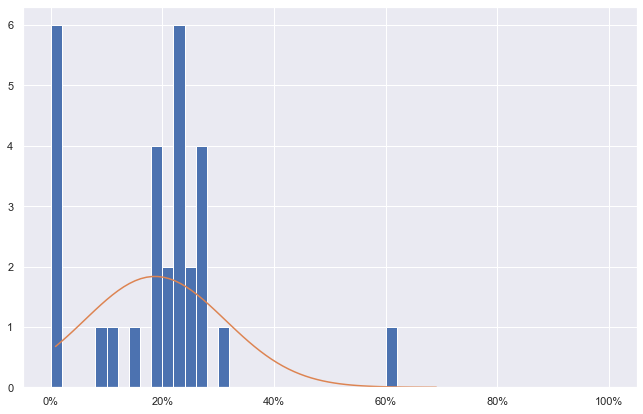

<Figure size 792x504 with 0 Axes>

In [100]:
plot_regiao(df_sel, municipio='ATALAIA DO NORTE', zona = 42, normal=True)

In [4]:
def print_media_votos(df,uf=None, zona = None,  secao = None, municipio = None):
    df_set = df
    if uf:
        df_set = df_set[df_set.SG_UF == uf]
    if municipio:
        df_set = df_set[df_set.NM_MUNICIPIO == municipio]
    if zona:
        df_set = df_set[df_set.NR_ZONA == zona]
    if secao:
        df_set = df_set[df_set.NR_SECAO == secao]
    print("Média de votos em urnas abaixo de 3 DP = {:.2f}".format(df_set[df_set.abaixo].total.mean()))
    print("Média de votos em urnas restantes = {:.2f}".format(df_set[~df_set.abaixo].total.mean()))

In [5]:
def contar_secoes(df, municipio, zona):
    df_set = df[(df.NM_MUNICIPIO == municipio) & (df.NR_ZONA == zona)]
    return len(df_set)

## 1.2 Preparo de dados

A base de nossa análise será a porcentagem de votos no Bolsonaro em cada secão eleitoral. 

In [6]:
df_orig = pd.read_csv('votacao_secao_2022_BR.csv', encoding='latin 1', sep = ';')

In [7]:
# Selecionar apenas colunas relevantes
df_sel = df_orig[df_orig.NR_TURNO == 2][['NR_TURNO','SG_UF','NM_MUNICIPIO','NR_ZONA','NR_SECAO', 'NR_VOTAVEL', 'QT_VOTOS', 'DS_LOCAL_VOTACAO_ENDERECO']].copy()

df_sel['LULA'] = df_sel.apply(lambda s: s.QT_VOTOS if s.NR_VOTAVEL == 13 else 0,axis=1)
df_sel['BOLSONARO'] = df_sel.apply(lambda s: s.QT_VOTOS if s.NR_VOTAVEL == 22 else 0,axis=1)

df_sel = df_sel.groupby(['NR_TURNO','SG_UF','NM_MUNICIPIO','NR_ZONA','NR_SECAO', 'DS_LOCAL_VOTACAO_ENDERECO'], as_index=False)[['LULA','BOLSONARO']].sum()

In [8]:
# Fazer coluna de total de votos e porcentagem de votos válidos para o Bolsonaro
df_sel['total'] = df_sel['LULA'] + df_sel['BOLSONARO']
df_sel['porcentagem'] = df_sel['BOLSONARO']/df_sel['total']

In [9]:
# Trazer dados estatisticos de cada endereço e zona eleitoral
enderecos = df_sel.groupby(['SG_UF','NR_ZONA', 'DS_LOCAL_VOTACAO_ENDERECO'], as_index=False)\
            .agg(media_end=('porcentagem','mean'),desv_padrao_end=('porcentagem','std'),
             quantidade_end=('porcentagem','count'))

zonas = df_sel.groupby(['SG_UF','NR_ZONA'], as_index=False)\
            .agg(media_zona=('porcentagem','mean'),desv_padrao_zona=('porcentagem','std'),
             quantidade_zona=('porcentagem','count'))

df_sel = df_sel.merge(enderecos, on=['SG_UF','NR_ZONA','DS_LOCAL_VOTACAO_ENDERECO'], how='left')
df_sel = df_sel.merge(zonas, on=['SG_UF','NR_ZONA'], how='left')

df_sel["z_score_end"] = (df_sel.porcentagem-df_sel.media_end)/df_sel.desv_padrao_end
df_sel["z_score_zona"] = (df_sel.porcentagem-df_sel.media_zona)/df_sel.desv_padrao_zona

In [10]:
print("Urnas com 0 votos para o Bolsonaro =",len(df_sel[df_sel.BOLSONARO == 0]))

Urnas com 0 votos para o Bolsonaro = 144


In [11]:
print("Urnas com 0 votos para o Lula =",len(df_sel[df_sel.LULA == 0]))

Urnas com 0 votos para o Lula = 5


# 2 - Análise exploratória

## 2.1 - Viés de urnas com poucos votos

Urnas com poucos votos possuem alta probabilidade de ter 100% dos votos em um único candidato. Existem, inclusive, 2 urnas com apenas 1 voto computado. Obviamente, em ambas as urnas 100% dos votos estão em uma única pessoa.

Para analisar as urnas mais relevantes, eliminaremos as urnas com menos de 50 votos.

In [12]:
print(f"Urnas com menos de 50 votos: {len(df_sel[df_sel.total < 50])}")

Urnas com menos de 50 votos: 702


In [13]:
df_sel_50 = df_sel[df_sel.total >= 50]

In [14]:
#Calcular numero de votos mantidos
len(df_sel_50)/len(df_sel)

0.9985128000881304

In [15]:
#Calcular média de votos para o Bolsonaro antes de remover
media_de_votos(df_sel)

0.49097594882827844

In [16]:
#Calcular média de votos para o Bolsonaro depois de remover
media_de_votos(df_sel_50)

0.49101267075302074

Ao eliminar as urnas com poucos votos, quase não houve alteração na média dos votos (0.003%).

Prosseguiremos então com a análise entre as urnas com mais de 50 votos.

In [17]:
print("Urnas com 0 votos para o Bolsonaro =",len(df_sel_50[df_sel_50.BOLSONARO == 0]))

Urnas com 0 votos para o Bolsonaro = 118


In [18]:
print("Urnas com 0 votos para o Lula =",len(df_sel_50[df_sel_50.LULA == 0]))

Urnas com 0 votos para o Lula = 1


Ainda há uma discrepância grande entre votos no Lula e no Bolsonaro. Analisaremos agora o viés de localização.

## 2.2 - Viés de localização

### 2.2.1 - Visão geral

Um dos possíveis motivos para este viés ocorrer é por existirem regiões remotas com alinhamento político extremo. Caso as urnas estejam acumuladas em uma mesma zona eleitoral, poderemos justificar que a votação é característica da região.

Um ponto importante a verificar é que, caso em um mesmo endereço haja uma diferença muito grande entre as urnas em um mesmo local (por exemplo, urna com 60% de votos para o Bolsonaro e outra com 0%), devemos justificar a existência desta discrepância, ou assumir que as urnas são provavelmente fraudadas.

In [19]:
# Quantidade de urnas sem votos para o Bolsonaro por estado
df_sel_50[(df_sel_50.BOLSONARO == 0)].groupby('SG_UF')['NM_MUNICIPIO'].count().reset_index(name="Urnas sem votos para Bolsonaro")

,SG_UF,Urnas sem votos para Bolsonaro
0,AC,2
1,AM,22
2,BA,16
3,CE,7
4,MA,42
5,MG,7
6,MS,1
7,MT,5
8,PA,5
9,PI,5


A princípio analizaremos algumas regiões do Amazonas e do Maranhão por serem as regiões com maior número de urnas sem votos para o Bolsonaro.

Após a análise destas duas regiões, faremos uma análise geral de todas as urnas do Brasil.

### 2.2.1 Amazonas

#### 2.2.1.1 - Visão geral

Primeiramente, verificaremos as regiões com urnas com 0 votos:

In [20]:
df_sel_50[(df_sel_50.BOLSONARO == 0) & (df_sel_50.SG_UF == 'AM')]

,NR_TURNO,SG_UF,NM_MUNICIPIO,NR_ZONA,NR_SECAO,DS_LOCAL_VOTACAO_ENDERECO,LULA,BOLSONARO,total,porcentagem,media_end,desv_padrao_end,quantidade_end,media_zona,desv_padrao_zona,quantidade_zona,z_score_end,z_score_zona
8906,2,AM,ATALAIA DO NORTE,42,25,"COM. SÃO LUIZ, ALDEIA INDIGENA, MÉDIO RIO JAVARI",138,0,138,0.0,0.000000,NaN,1,0.186807,0.128282,29,NaN,-1.456226
8909,2,AM,ATALAIA DO NORTE,42,28,"COM. SÃO SEBASTIÃO, ALDEIA INDIGENA, MÉDIO RIO...",127,0,127,0.0,0.000000,NaN,1,0.186807,0.128282,29,NaN,-1.456226
8910,2,AM,ATALAIA DO NORTE,42,29,"COM. REMANSINHO, ALDEIA INDIGENA, RIO ITACOAÍ",175,0,175,0.0,0.000000,NaN,1,0.186807,0.128282,29,NaN,-1.456226
8914,2,AM,ATALAIA DO NORTE,42,37,"COM. MARONAL, ALDEIA INDIGENA, ALTO RIO CURUÇÁ",107,0,107,0.0,0.000000,NaN,1,0.186807,0.128282,29,NaN,-1.456226
9090,2,AM,BARREIRINHA,26,63,"COM. SIMÃO, RIO ANDIRÁ, MARGEM ESQUERDA",237,0,237,0.0,0.001656,0.002341,2,0.083193,0.040356,61,-0.707107,-2.061509
9470,2,AM,CARAUARI,21,96,"COMUNIDADE SÃO RAIMUNDO, RIO JURUÁ, MARGEM DIR...",91,0,91,0.0,0.000000,NaN,1,0.205426,0.070010,63,NaN,-2.934236
10102,2,AM,IPIXUNA,45,52,"COMUNIDADE ALDEIA PIAU, ZONA RURAL INDÍGENA",94,0,94,0.0,0.016854,0.023835,2,0.455346,0.170454,67,-0.707107,-2.671366
15553,2,AM,SANTA ISABEL DO RIO NEGRO,30,22,"RIO MARAUIA, MISSÃO SALESIANA",196,0,196,0.0,0.000000,0.000000,2,0.259727,0.092087,27,NaN,-2.820441
15557,2,AM,SANTA ISABEL DO RIO NEGRO,30,26,"RIO MARAUIA, MISSÃO SALESIANA",156,0,156,0.0,0.000000,0.000000,2,0.259727,0.092087,27,NaN,-2.820441
15569,2,AM,SANTO ANTÔNIO DO IÇÁ,47,10,"COM. VILA DE BETANIA,RIO IÇA, MARGEM DIREITA, ...",303,0,303,0.0,0.003728,0.002412,6,0.228546,0.130886,77,-1.545588,-1.746140


Verificaremos então as três zonas eleitorais com maior número de urnas com 100% dos votos para o Lula. As zonas eleitorais 42, 19 e 22. Estas 3 regiões representam mais da metade das urnas "suspeitas".

#### 2.2.1.2 - Atalaia do Norte, zona 42

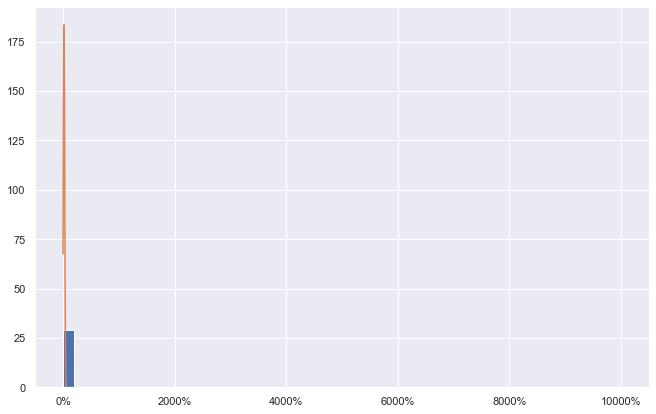

<Figure size 792x504 with 0 Axes>

In [97]:
plot_regiao(df_sel, municipio='ATALAIA DO NORTE', zona = 42, normal=True)

Apesar de se tratar da mesma região, é evidente que há uma diferença grande entre as urnas, tendo 6 urnas sem votos para o Bolsonaro e uma urna com 60% de votos.

Analisaremos então os endereços desta zona eleitoral.

In [22]:
print("Urnas com mais de 50% de votos para o Bolsonaro")
df_sel[(df_sel.NR_ZONA == 42) & (df_sel.SG_UF == 'AM') & (df_sel.porcentagem < 0.10)]

Urnas com mais de 50% de votos para o Bolsonaro


,NR_TURNO,SG_UF,NM_MUNICIPIO,NR_ZONA,NR_SECAO,DS_LOCAL_VOTACAO_ENDERECO,LULA,BOLSONARO,total,porcentagem,media_end,desv_padrao_end,quantidade_end,media_zona,desv_padrao_zona,quantidade_zona,z_score_end,z_score_zona
8906,2,AM,ATALAIA DO NORTE,42,25,"COM. SÃO LUIZ, ALDEIA INDIGENA, MÉDIO RIO JAVARI",138,0,138,0.000000,0.000000,NaN,1,0.186807,0.128282,29,NaN,-1.456226
8907,2,AM,ATALAIA DO NORTE,42,26,"COM. LOBO, ALDEIA INDIGENA, RIO JAQUIRANA",257,1,258,0.003876,0.003876,NaN,1,0.186807,0.128282,29,NaN,-1.426012
8908,2,AM,ATALAIA DO NORTE,42,27,"COM. VIDA NOVA, ALDEIA INDIGENA, ALTO RIO ITUÍ",178,19,197,0.096447,0.096447,NaN,1,0.186807,0.128282,29,NaN,-0.704392
8909,2,AM,ATALAIA DO NORTE,42,28,"COM. SÃO SEBASTIÃO, ALDEIA INDIGENA, MÉDIO RIO...",127,0,127,0.000000,0.000000,NaN,1,0.186807,0.128282,29,NaN,-1.456226
8910,2,AM,ATALAIA DO NORTE,42,29,"COM. REMANSINHO, ALDEIA INDIGENA, RIO ITACOAÍ",175,0,175,0.000000,0.000000,NaN,1,0.186807,0.128282,29,NaN,-1.456226
8911,2,AM,ATALAIA DO NORTE,42,30,"COM. PARAISO, ALDEIA INDIGENA, RIO BRANCO, MAR...",107,1,108,0.009259,0.009259,NaN,1,0.186807,0.128282,29,NaN,-1.384047
8914,2,AM,ATALAIA DO NORTE,42,37,"COM. MARONAL, ALDEIA INDIGENA, ALTO RIO CURUÇÁ",107,0,107,0.000000,0.000000,NaN,1,0.186807,0.128282,29,NaN,-1.456226


In [23]:
print("Urnas com mais de 50% de votos para o Bolsonaro")
df_sel[(df_sel.NR_ZONA == 42) & (df_sel.SG_UF == 'AM') & (df_sel.porcentagem > 0.1)]

Urnas com mais de 50% de votos para o Bolsonaro


,NR_TURNO,SG_UF,NM_MUNICIPIO,NR_ZONA,NR_SECAO,DS_LOCAL_VOTACAO_ENDERECO,LULA,BOLSONARO,total,porcentagem,media_end,desv_padrao_end,quantidade_end,media_zona,desv_padrao_zona,quantidade_zona,z_score_end,z_score_zona
8886,2,AM,ATALAIA DO NORTE,42,1,RUA NOVA I S/N,184,66,250,0.264000,0.259991,0.028184,8,0.186807,0.128282,29,0.142239,0.601741
8887,2,AM,ATALAIA DO NORTE,42,2,RUA NOVA I S/N,157,69,226,0.305310,0.259991,0.028184,8,0.186807,0.128282,29,1.607944,0.923765
8888,2,AM,ATALAIA DO NORTE,42,3,RUA NOVA I S/N,167,54,221,0.244344,0.259991,0.028184,8,0.186807,0.128282,29,-0.555177,0.448516
8889,2,AM,ATALAIA DO NORTE,42,4,AV PEDRO TEIXEIRA,171,43,214,0.200935,0.209229,0.019340,7,0.186807,0.128282,29,-0.428866,0.110126
8890,2,AM,ATALAIA DO NORTE,42,5,RUA AUGUSTO LUZEIRO - SN,174,40,214,0.186916,0.210787,0.037349,5,0.186807,0.128282,29,-0.639150,0.000845
8891,2,AM,ATALAIA DO NORTE,42,6,PELOTÃO DE FRONTEIRA ESTIRÃO DO EQUADOR,54,84,138,0.608696,0.608696,NaN,1,0.186807,0.128282,29,NaN,3.288758
8892,2,AM,ATALAIA DO NORTE,42,7,PELOTÃO DE FRONTEIRA PALMEIRAS DO JAVARI,134,15,149,0.100671,0.100671,NaN,1,0.186807,0.128282,29,NaN,-0.671461
8893,2,AM,ATALAIA DO NORTE,42,8,RUA AUGUSTO LUZEIRO - SN,150,46,196,0.234694,0.210787,0.037349,5,0.186807,0.128282,29,0.640088,0.373291
8894,2,AM,ATALAIA DO NORTE,42,9,AV PEDRO TEIXEIRA,177,54,231,0.233766,0.209229,0.019340,7,0.186807,0.128282,29,1.268744,0.366059
8895,2,AM,ATALAIA DO NORTE,42,10,RUA AUGUSTO LUZEIRO - SN,171,51,222,0.229730,0.210787,0.037349,5,0.186807,0.128282,29,0.507174,0.334593


A seção com 60% de votos no Bolsonaro está no **pelotão de fronteira estirão do Equador** enquanto as seções com 0 votos estão em aldeias indígenas.

Todas as aldeias indígenas possuem uma média abaixo de 10% de votos no Bolsonaro. Fica evidente que o viés nas urnas são facilmente justificáveis e as amostras não são aleatórias dentro da zona eleitoral.

Vamos checar agora a zona 19, SÃO GABRIEL DA CACHOEIRA.

#### 2.2.1.3 - São Gabriel da Cachoeira

In [24]:
print("Número de seções eleitorais:",
      len(df_sel_50[(df_sel_50.NR_ZONA == 19) & 
           (df_sel_50.NM_MUNICIPIO == 'SÃO GABRIEL DA CACHOEIRA') & 
           (df_sel_50.SG_UF == 'AM')]))

Número de seções eleitorais: 97


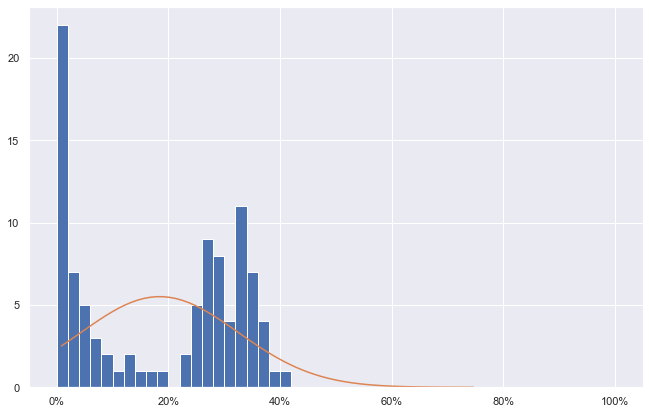

<Figure size 792x504 with 0 Axes>

In [25]:
plot_regiao(df_sel_50, municipio='SÃO GABRIEL DA CACHOEIRA', zona = 19, normal=True)

Novamente, a mesma zona eleitoral possui valores discrepantes.

In [26]:
df_sel_50[(df_sel_50.NR_ZONA == 19) & 
           (df_sel_50.NM_MUNICIPIO == 'SÃO GABRIEL DA CACHOEIRA') & 
           (df_sel_50.SG_UF == 'AM')].value_counts('DS_LOCAL_VOTACAO_ENDERECO')

DS_LOCAL_VOTACAO_ENDERECO
PRAÇA NÚNCIO APOSTÓLICO DOM SEBASTIÃO BÁGGIO                 20
RUA QUATRO S/N                                               10
BR 307, KM 3                                                  9
COM. IAUARETÊ (DISTRITO),  RIO WAUPÉS                         8
RUA CRISPINIANO DA SILVA, 169                                 6
AV. PAU BRASIL S/N                                            5
COM. FOZ DO IÇANA                                             3
COM. (DISTRITO) PARI-CACHOEIRA                                3
COM. MATURACÁ, RIO MATURACÁ AFLUENTE DO RIO CAUBURIS          3
COM. CANADÁ, RIO AYARI, MARGEM DIREITA                        2
COM. TUNUÍ, RIO IÇANA                                         2
COM. TARACUÁ (DISTRITO)                                       2
COM. SÃO JOAQUIM,  RIO IÇANA                                  2
COM. BOCA DA ESTRADA, RIO TIQUIÉ, MARGEM ESQUERDA             2
COM. CUCUÍ (DISTRITO) KM 210                                  2
COM. DE NAZARÉ

Em uma análise inicial separaremos as comunidades dos demais endereços.

In [27]:
regiao_1 = df_sel_50.loc[df_sel_50['DS_LOCAL_VOTACAO_ENDERECO'].str.contains("COM.", case=False) & 
                              (df_sel_50.NR_ZONA == 19) & 
                               (df_sel_50.NM_MUNICIPIO == 'SÃO GABRIEL DA CACHOEIRA')]
regiao_2 = df_sel_50.loc[~df_sel_50['DS_LOCAL_VOTACAO_ENDERECO'].str.contains("COM.", case=False) & 
                              (df_sel_50.NR_ZONA == 19) & 
                               (df_sel_50.NM_MUNICIPIO == 'SÃO GABRIEL DA CACHOEIRA')]

Zonas eleitorais em comunidades de São Gabriel da Cachoeira


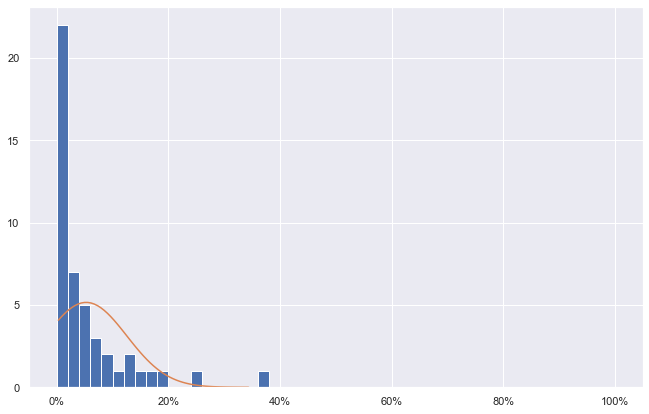

<Figure size 792x504 with 0 Axes>

In [28]:
print("Zonas eleitorais em comunidades de São Gabriel da Cachoeira")
plot_regiao(regiao_1, normal=True)

Demais zonas eleitorais de São Gabriel da Cachoeira


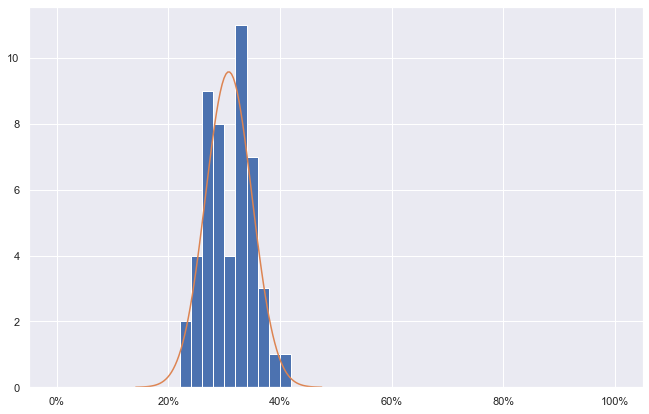

<Figure size 792x504 with 0 Axes>

In [29]:
print("Demais zonas eleitorais de São Gabriel da Cachoeira")
plot_regiao(regiao_2, normal=True)

Novamente, esta simples separação já deixa evidente que existe um viés nos votos em comunidades e fora de comunidades.

A última zona eleitoral do amazonas que analisaremos é a de SÃO PAULO DE OLIVENÇA.

#### 2.2.1.4 - São Paulo de Olivença

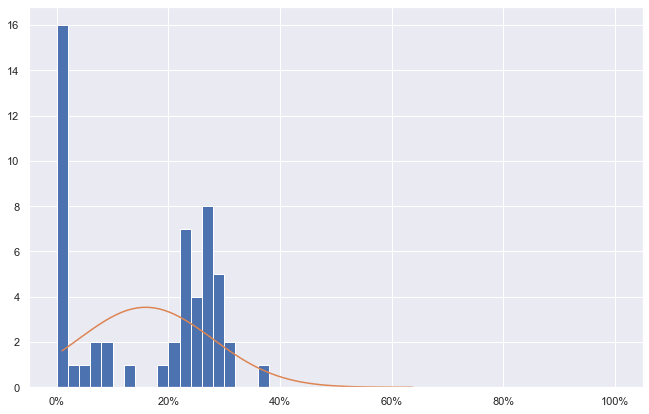

<Figure size 792x504 with 0 Axes>

In [30]:
plot_regiao(df_sel_50, municipio='SÃO PAULO DE OLIVENÇA', zona = 22, normal=True)

In [31]:
df_sel_50[(df_sel_50.NR_ZONA == 22) & 
           (df_sel_50.NM_MUNICIPIO == 'SÃO PAULO DE OLIVENÇA') & 
           (df_sel_50.SG_UF == 'AM')].value_counts('DS_LOCAL_VOTACAO_ENDERECO')

DS_LOCAL_VOTACAO_ENDERECO
RUA MONSENHOR EVANGELISTA, SN                              9
ESTRADA DO BONFIM, SN                                      7
COM. CAMPO ALEGRE, RIO SOLIMÕES, MARGEM ESQUERDA           6
ESTRADA DO AJARATUBA, S/N                                  5
COM. VENDAVAL, RIO SOLIMÕES, MARGEM ESQUERDA               4
RUA TRINTA E UM DE MAIO, SN                                4
AVENIDA BRASIL, SN                                         3
COM. SANTA RITA DO WEILL, RIO SOLIMÕES, MARGEM ESQUERDA    3
COM. BOA ESPERANCA, RIO SOLIMÕES, MARGEM ESQUERDA          2
COM. BOM SUCESSO, RIO CAMATIÃ, MARGEM DIREITA              2
COM. SANTA INES, RIO SOLIMÕES, MARGEM ESQUERDA             2
COM. VERA CRUZ, RIO SOLIMÕES, MARGEM DIREITA               2
COM. BOM JESUS, RIO SOLIMÕES, MARGEM ESQUERDA              1
COM. DE TUPY II, RIO SOLIMÕES, MARGEM DIREITA              1
COM. DECUÃPU, RIO CAMATIÃ, MARGEM ESQUERDA                 1
COM. PARANAPARA, RIO CAMATIÃ, MARGEM DIREITA               

Novamente, separaremos as comunidades das demais regiões.

In [32]:
regiao_1 = df_sel_50.loc[df_sel_50['DS_LOCAL_VOTACAO_ENDERECO'].str.contains("COM.", case=False) & 
                              (df_sel_50.NR_ZONA == 22) & 
                               (df_sel_50.NM_MUNICIPIO == 'SÃO PAULO DE OLIVENÇA')]
regiao_2 = df_sel_50.loc[~df_sel_50['DS_LOCAL_VOTACAO_ENDERECO'].str.contains("COM.", case=False) & 
                              (df_sel_50.NR_ZONA == 22) & 
                               (df_sel_50.NM_MUNICIPIO == 'SÃO PAULO DE OLIVENÇA')]

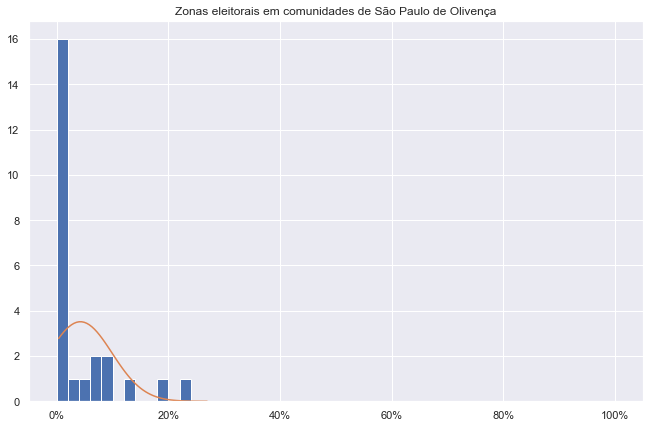

<Figure size 792x504 with 0 Axes>

In [33]:
plot_regiao(regiao_1, normal=True,  title = "Zonas eleitorais em comunidades de São Paulo de Olivença")

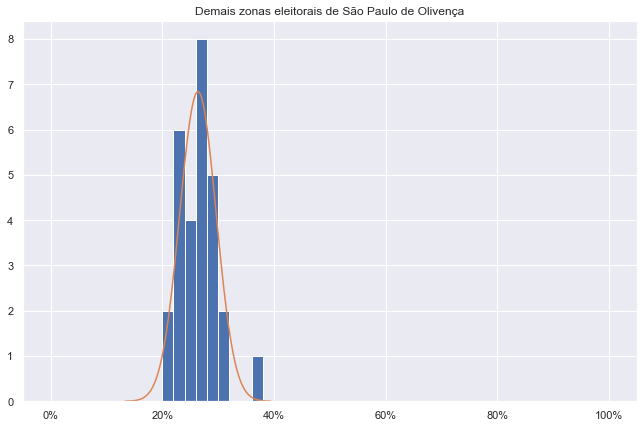

<Figure size 792x504 with 0 Axes>

In [34]:
plot_regiao(regiao_2, normal=True, title = "Demais zonas eleitorais de São Paulo de Olivença")

Com esta simples separação, fica evidente o viés causado por zonas eleitorais dentro/fora de comunidades.

Como as amostras não são aleatórias, o teorema do limite central não se aplica no conjunto total desta zona eleitoral. Não há, portanto, evidências de impossibilidades estatísticas nas urnas analisadas.

### 2.2.2 Maranhão

#### 2.2.2.1 Visão geral

In [35]:
print("Quantidade de urnas com 0 votos:")
len(df_sel_50[(df_sel_50.BOLSONARO == 0) & (df_sel_50.SG_UF == 'MA')])

Quantidade de urnas com 0 votos:


42

In [36]:
df_sel_50[(df_sel_50.BOLSONARO == 0) & (df_sel_50.SG_UF == 'MA')]

,NR_TURNO,SG_UF,NM_MUNICIPIO,NR_ZONA,NR_SECAO,DS_LOCAL_VOTACAO_ENDERECO,LULA,BOLSONARO,total,porcentagem,media_end,desv_padrao_end,quantidade_end,media_zona,desv_padrao_zona,quantidade_zona,z_score_end,z_score_zona
106223,2,MA,AMARANTE DO MARANHÃO,99,127,RUA PRINCIPAL,73,0,73,0.0,0.141930,0.137808,5,0.383654,0.120537,138,-1.029911,-3.182886
107289,2,MA,BACURI,107,38,POVOADO DE BATE PÉ,106,0,106,0.0,0.000000,NaN,1,0.166706,0.106301,132,NaN,-1.568243
107505,2,MA,BARRA DO CORDA,23,19,POVOADO JATOBA,74,0,74,0.0,0.000000,NaN,1,0.319614,0.134063,220,NaN,-2.384062
107840,2,MA,BARREIRINHAS,56,175,"RUA PRINCIPAL, S/N, POVOADO FOME",87,0,87,0.0,0.000000,NaN,1,0.176850,0.116654,171,NaN,-1.516023
107889,2,MA,BARREIRINHAS,56,239,"RUA PRINCIPAL, S/N, POVOADO BARTOLOMEU",51,0,51,0.0,0.000000,NaN,1,0.176850,0.116654,171,NaN,-1.516023
108412,2,MA,BREJO,24,253,POVOADO CAROBINHAS,61,0,61,0.0,0.000000,NaN,1,0.179874,0.092873,217,NaN,-1.936774
109089,2,MA,CARUTAPERA,55,69,"RUA PRINCIPAL, S/N.",53,0,53,0.0,0.235108,0.195659,21,0.281362,0.106799,88,-1.201619,-2.634497
110539,2,MA,CURURUPU,14,175,POVOADO ROÇA DE BAIXO,56,0,56,0.0,0.000000,NaN,1,0.156064,0.081999,99,NaN,-1.903249
110895,2,MA,FERNANDO FALCÃO,97,185,ALDEIA ESCALVADO,283,0,283,0.0,0.001747,0.002019,4,0.205158,0.132001,79,-0.865264,-1.554213
110912,2,MA,FERNANDO FALCÃO,97,205,ALDEIA ESCALVADO,310,0,310,0.0,0.001747,0.002019,4,0.205158,0.132001,79,-0.865264,-1.554213


Analisaremos as zonas 97, 103 e 73

#### 2.2.2.1 Fernando Falcão, zona 97

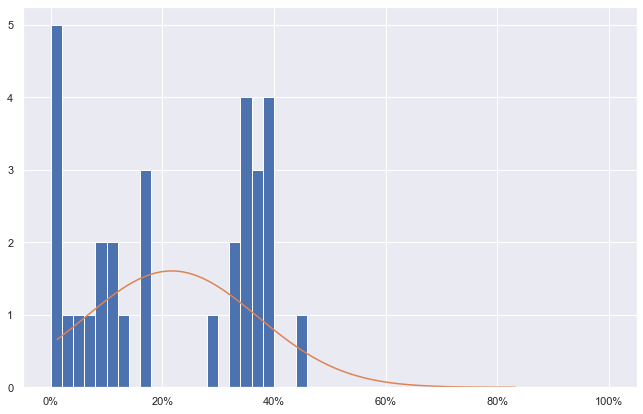

<Figure size 792x504 with 0 Axes>

In [37]:
plot_regiao(df_sel, municipio='FERNANDO FALCÃO', zona = 97, normal=True)

Novamente, analisaremos os endereços da zona 97.

In [38]:
print("Urnas com menos de 20% de votos para o Bolsonaro")
df_sel[(df_sel.NM_MUNICIPIO == 'FERNANDO FALCÃO') & (df_sel.NR_ZONA == 97) & (df_sel.SG_UF == 'MA') & (df_sel.porcentagem < 0.2)]

Urnas com menos de 20% de votos para o Bolsonaro


,NR_TURNO,SG_UF,NM_MUNICIPIO,NR_ZONA,NR_SECAO,DS_LOCAL_VOTACAO_ENDERECO,LULA,BOLSONARO,total,porcentagem,media_end,desv_padrao_end,quantidade_end,media_zona,desv_padrao_zona,quantidade_zona,z_score_end,z_score_zona
110884,2,MA,FERNANDO FALCÃO,97,172,POVOADO CATINGUEIRO,194,20,214,0.093458,0.093458,NaN,1,0.205158,0.132001,79,NaN,-0.846204
110885,2,MA,FERNANDO FALCÃO,97,174,"POVOADO VENEZA, ZONA RURAL - FERNANDO FALCÃO/MA",95,12,107,0.112150,0.112150,NaN,1,0.205158,0.132001,79,NaN,-0.704602
110886,2,MA,FERNANDO FALCÃO,97,175,ALDEIA PORQUINHOS,207,8,215,0.037209,0.038967,0.002485,2,0.205158,0.132001,79,-0.707107,-1.272326
110887,2,MA,FERNANDO FALCÃO,97,176,ALDEIA PORQUINHOS,212,9,221,0.040724,0.038967,0.002485,2,0.205158,0.132001,79,0.707107,-1.245700
110888,2,MA,FERNANDO FALCÃO,97,177,POVOADO BOCA DA MATA,121,13,134,0.097015,0.097015,NaN,1,0.205158,0.132001,79,NaN,-0.819257
110889,2,MA,FERNANDO FALCÃO,97,178,POVOADO ESCONDIDO DO INDIO,197,43,240,0.179167,0.179167,NaN,1,0.205158,0.132001,79,NaN,-0.196901
110890,2,MA,FERNANDO FALCÃO,97,180,POVOADO BARREIRO DOS LOBOS - ZONA RURAL,73,16,89,0.179775,0.179775,NaN,1,0.205158,0.132001,79,NaN,-0.192290
110894,2,MA,FERNANDO FALCÃO,97,184,ALDEIA ESCALVADO,277,1,278,0.003597,0.001747,0.002019,4,0.205158,0.132001,79,0.916606,-1.526962
110895,2,MA,FERNANDO FALCÃO,97,185,ALDEIA ESCALVADO,283,0,283,0.000000,0.001747,0.002019,4,0.205158,0.132001,79,-0.865264,-1.554213
110896,2,MA,FERNANDO FALCÃO,97,186,ALDEIA ESCALVADO,294,1,295,0.003390,0.001747,0.002019,4,0.205158,0.132001,79,0.813922,-1.528532


In [39]:
print("Urnas com mais de 20% de votos para o Bolsonaro")
df_sel[(df_sel.NM_MUNICIPIO == 'FERNANDO FALCÃO') & (df_sel.NR_ZONA == 97) & (df_sel.SG_UF == 'MA') & (df_sel.porcentagem > 0.2)]

Urnas com mais de 20% de votos para o Bolsonaro


,NR_TURNO,SG_UF,NM_MUNICIPIO,NR_ZONA,NR_SECAO,DS_LOCAL_VOTACAO_ENDERECO,LULA,BOLSONARO,total,porcentagem,media_end,desv_padrao_end,quantidade_end,media_zona,desv_padrao_zona,quantidade_zona,z_score_end,z_score_zona
110891,2,MA,FERNANDO FALCÃO,97,181,POVOADO LEANDRO,131,83,214,0.387850,0.370242,0.027821,4,0.205158,0.132001,79,0.632931,1.384023
110892,2,MA,FERNANDO FALCÃO,97,182,POVOADO LEANDRO,151,78,229,0.340611,0.370242,0.027821,4,0.205158,0.132001,79,-1.065020,1.026154
110893,2,MA,FERNANDO FALCÃO,97,183,POVOADO LEANDRO,141,77,218,0.353211,0.370242,0.027821,4,0.205158,0.132001,79,-0.612141,1.121606
110899,2,MA,FERNANDO FALCÃO,97,189,POVOADO BURITI,152,101,253,0.399209,0.406911,0.032958,3,0.205158,0.132001,79,-0.233682,1.470076
110900,2,MA,FERNANDO FALCÃO,97,190,POVOADO BURITI,156,95,251,0.378486,0.406911,0.032958,3,0.205158,0.132001,79,-0.862467,1.313082
110901,2,MA,FERNANDO FALCÃO,97,191,POVOADO BURITI,132,105,237,0.443038,0.406911,0.032958,3,0.205158,0.132001,79,1.096149,1.802107
110904,2,MA,FERNANDO FALCÃO,97,196,RUA EMILIANO SN,161,87,248,0.350806,0.348531,0.034092,6,0.205158,0.132001,79,0.066751,1.103389
110905,2,MA,FERNANDO FALCÃO,97,197,RUA EMILIANO SN,159,83,242,0.342975,0.348531,0.034092,6,0.205158,0.132001,79,-0.162958,1.044062
110906,2,MA,FERNANDO FALCÃO,97,198,RUA EMILIANO SN,153,78,231,0.337662,0.348531,0.034092,6,0.205158,0.132001,79,-0.318796,1.003814
110907,2,MA,FERNANDO FALCÃO,97,199,RUA EMILIANO SN,139,83,222,0.373874,0.348531,0.034092,6,0.205158,0.132001,79,0.743372,1.278141


As urnas sem voto no Bolsonaro estão todas na ALDEIA ESCALVADO, onde tivemos duas urnas com 0 votos e duas urnas com 1 voto.

Desta vez, não há uma clara divisão entre porcentagem de votos em aldeias e povoados, porém não há intersecção entre locais com urnas com menos de 20% e urnas com mais de 20% dos votos no Bolsonaro. Fica evidente então que cada local tem uma característica diferente e confirmamos o viés de localização.

Outro ponto a se observar é que todas as urnas com menos de 20% de votos no Bolsonaro estão em aldeias ou povoados.

#### 2.2.2.2 Montes Altos, zona 103

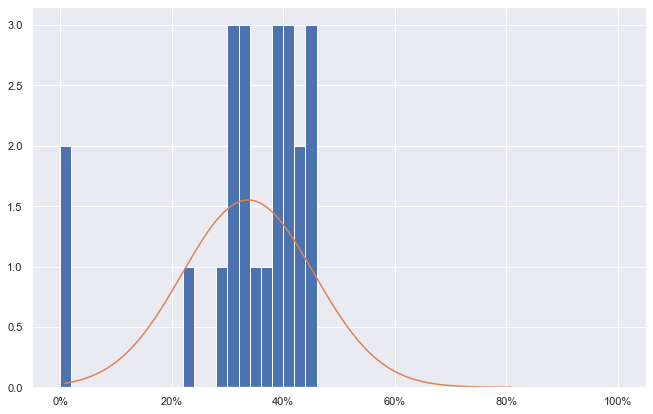

<Figure size 792x504 with 0 Axes>

In [40]:
plot_regiao(df_sel, municipio='MONTES ALTOS', zona = 103, normal=True)

In [41]:
df_sel[(df_sel.NM_MUNICIPIO == 'MONTES ALTOS') & (df_sel.NR_ZONA == 103) & (df_sel.SG_UF == 'MA')]

,NR_TURNO,SG_UF,NM_MUNICIPIO,NR_ZONA,NR_SECAO,DS_LOCAL_VOTACAO_ENDERECO,LULA,BOLSONARO,total,porcentagem,media_end,desv_padrao_end,quantidade_end,media_zona,desv_padrao_zona,quantidade_zona,z_score_end,z_score_zona
113678,2,MA,MONTES ALTOS,103,1,"AV. FABRÍCIO FERRAZ, S/N",193,94,287,0.327526,0.327526,NaN,1,0.353951,0.082758,85,NaN,-0.319299
113679,2,MA,MONTES ALTOS,103,4,"RUA PARSONDAS DE CARVALHO, S/N.",146,85,231,0.367965,0.377082,0.069871,3,0.353951,0.082758,85,-0.130480,0.169343
113680,2,MA,MONTES ALTOS,103,5,"RUA PARSONDAS DE CARVALHO, S/N.",152,69,221,0.312217,0.377082,0.069871,3,0.353951,0.082758,85,-0.928355,-0.504282
113681,2,MA,MONTES ALTOS,103,6,"TRAVESSA CENTRAL, S/N",156,69,225,0.306667,0.268718,0.053668,2,0.353951,0.082758,85,0.707107,-0.571351
113682,2,MA,MONTES ALTOS,103,7,"TRAVESSA CENTRAL, S/N",170,51,221,0.230769,0.268718,0.053668,2,0.353951,0.082758,85,-0.707107,-1.488448
113683,2,MA,MONTES ALTOS,103,8,"RUA EUGENIO BARROS, S/N",197,91,288,0.315972,0.320087,0.026453,4,0.353951,0.082758,85,-0.155567,-0.458909
113684,2,MA,MONTES ALTOS,103,10,"RUA EUGENIO BARROS, S/N",203,107,310,0.345161,0.320087,0.026453,4,0.353951,0.082758,85,0.947857,-0.106207
113685,2,MA,MONTES ALTOS,103,12,"RUA EUGENIO BARROS, S/N",199,100,299,0.334448,0.320087,0.026453,4,0.353951,0.082758,85,0.542872,-0.235657
113686,2,MA,MONTES ALTOS,103,14,"RUA EUGENIO BARROS, S/N",108,43,151,0.284768,0.320087,0.026453,4,0.353951,0.082758,85,-1.335162,-0.835958
113687,2,MA,MONTES ALTOS,103,15,"RUA QUINTILIANO JOSE TAVARES, S/N",106,80,186,0.430108,0.430108,NaN,1,0.353951,0.082758,85,NaN,0.920230


No município de Montes Altos temos uma grande discrepância em **urnas no mesmo endereço**. O único porém é que o endereço está descrito como **RUA PRINCIPAL, S/N**, ou seja, rua principal, sem número. Existe então a possibilidade da tabela fornecida pelo TSE estar com o endereço incompleto nestas áreas.

In [42]:
df_sel[(df_sel.NM_MUNICIPIO == 'MONTES ALTOS') & (df_sel.NR_ZONA == 103) & (df_sel.SG_UF == 'MA') & (df_sel.DS_LOCAL_VOTACAO_ENDERECO == 'RUA PRINCIPAL, S/N')]

,NR_TURNO,SG_UF,NM_MUNICIPIO,NR_ZONA,NR_SECAO,DS_LOCAL_VOTACAO_ENDERECO,LULA,BOLSONARO,total,porcentagem,media_end,desv_padrao_end,quantidade_end,media_zona,desv_padrao_zona,quantidade_zona,z_score_end,z_score_zona
113696,2,MA,MONTES ALTOS,103,24,"RUA PRINCIPAL, S/N",31,21,52,0.403846,0.221281,0.14201,9,0.353951,0.082758,85,1.285582,0.602904
113697,2,MA,MONTES ALTOS,103,26,"RUA PRINCIPAL, S/N",159,81,240,0.337500,0.221281,0.14201,9,0.353951,0.082758,85,0.818388,-0.198781
113698,2,MA,MONTES ALTOS,103,28,"RUA PRINCIPAL, S/N",260,0,260,0.000000,0.221281,0.14201,9,0.353951,0.082758,85,-1.558203,-4.276917
113700,2,MA,MONTES ALTOS,103,80,"RUA PRINCIPAL, S/N",264,0,264,0.000000,0.221281,0.14201,9,0.353951,0.082758,85,-1.558203,-4.276917


Verificando o endereço das seções eleitorais 24, 26, 28 e 80 no site https://www.descubraonline.com/eleicoes/, encontramos os seguintes dados:

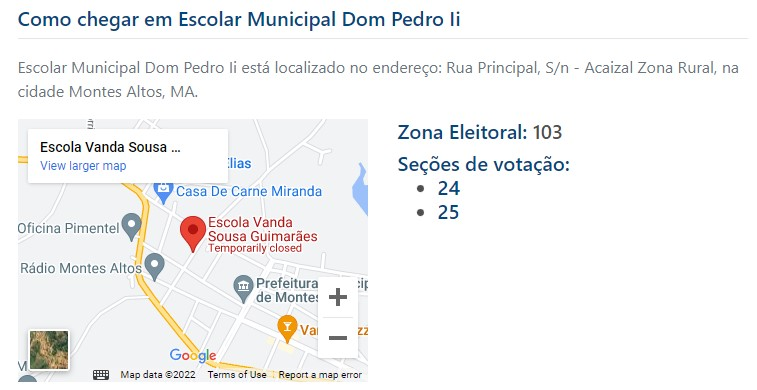

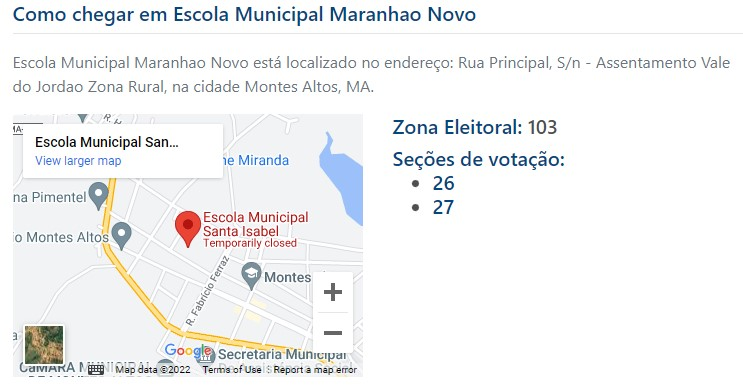

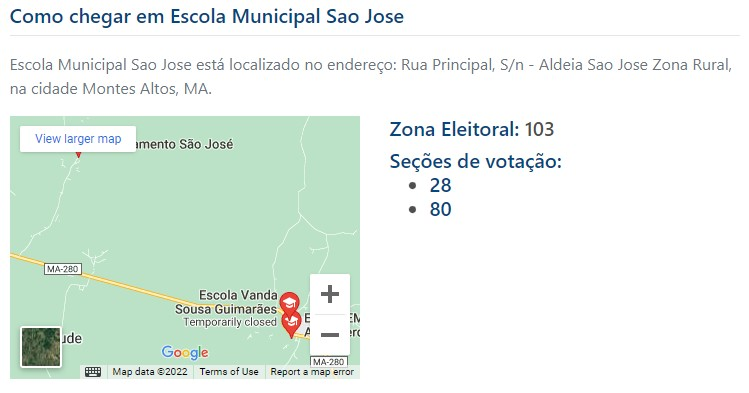

Verificamos então que, apesar de ter o mesmo endereço na tabela do TSE, as seções eleitorais 24 e 26 estão em locais diferentes. As seções 28 e 80 estão no mesmo local (Pô TSE, puxa a orelha do estagiário) e ambas as urnas com 0 votos no Bolsonaro estão neste local, **Aldeia São Jose**.

Para facilitar a continuação de nossa análise, corrigirei o endereço na tabela do TSE

In [43]:
df_sel.loc[[113698,113700], 'DS_LOCAL_VOTACAO_ENDERECO'] = 'ALDEIA SAO JOSE'

In [44]:
df_sel.loc[113697, 'DS_LOCAL_VOTACAO_ENDERECO'] = 'RUA PRINCIPAL, ASSENTAMENTO VALE DO JORDAO'

In [45]:
df_sel.loc[113696, 'DS_LOCAL_VOTACAO_ENDERECO'] = 'RUA PRINCIPAL, ACAIZAL'

Removendo as urnas da aldeia São José, temos o seguinte gráfico na zona 103:

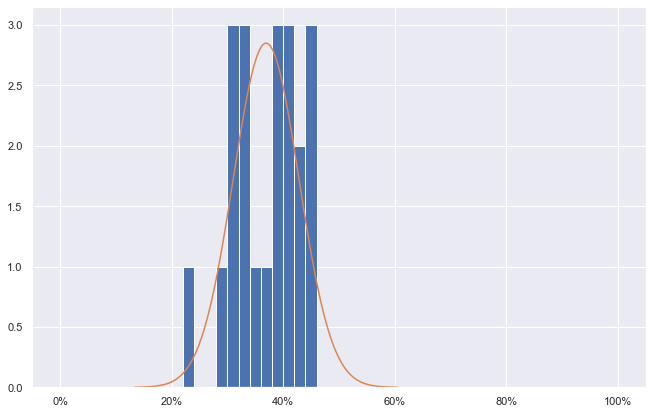

<Figure size 792x504 with 0 Axes>

In [46]:
regiao = df_sel[(df_sel.NM_MUNICIPIO == 'MONTES ALTOS') & 
                (df_sel.NR_ZONA == 103) & 
                (df_sel.SG_UF == 'MA') & 
                (~df_sel.NR_SECAO.isin([28,80]))]
plot_regiao(regiao, normal=True)

As demais urnas da zona 103 não possuem grande discrepância, portanto fica evidente que existe um viés nas urnas da Aldeia São José, onde **todos os eleitores votaram no Lula**.

#### 2.2.2.3 São Benedito do Rio Preto, zona 73

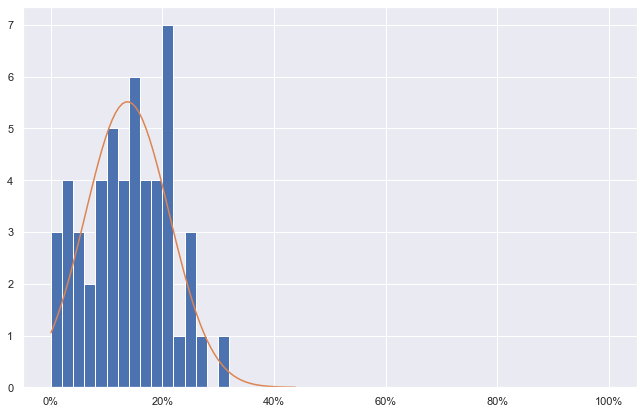

<Figure size 792x504 with 0 Axes>

In [47]:
plot_regiao(df_sel, municipio='SÃO BENEDITO DO RIO PRETO', zona = 73, normal=True)

Ao verificar os endereços, encontramos seções em endereços de cidades e endereços em povoados.

In [48]:
df_sel[(df_sel.NM_MUNICIPIO == 'SÃO BENEDITO DO RIO PRETO') & (df_sel.NR_ZONA == 73) & (df_sel.SG_UF == 'MA')].value_counts('DS_LOCAL_VOTACAO_ENDERECO')

DS_LOCAL_VOTACAO_ENDERECO
RUA CAPITAO ALMIR MESQUITA                       6
TRAVESSA MANOEL MESQUITA, S/N                    5
RUA ACELINO SOUSA, S/N                           4
RUA FRANCISCO BRAGA DE MESQUITA                  4
RUA ADÉLIA RABELO                                4
AVENIDA BRASIL                                   3
ZONA RURAL                                       3
POVOADO SÃO JOSÉ DOS COSTAS - ZONA RURAL         2
RUA JOÃO SOUSA                                   2
RUA BEIRA CAMPO                                  2
POVOADO PICOS - ZONA RURAL                       1
POVOADO BARRA GRANDE - ZONA RURAL                1
RUA JOSÉ MESQUITA, S/N                           1
RUA JERÔNIMO FERREIRA                            1
POVOADO BURITIZAL DOS FLORÊNCIOS - ZONA RURAL    1
POVOADO COCALZINHO                               1
POVOADO GUABIRABAL                               1
POVOADO MARÇAL - ZONA RURAL                      1
RUA 25 DE MARÇO, S/N                             1
POVOA

Separando as seções dentro de povoados e fora de povoados, temos as seguintes distribuições:

In [49]:
regiao_1 = df_sel.loc[df_sel['DS_LOCAL_VOTACAO_ENDERECO'].str.contains("POVOADO", case=False) & 
                              (df_sel.NR_ZONA == 73) & 
                               (df_sel.NM_MUNICIPIO == 'SÃO BENEDITO DO RIO PRETO') &
                                 (df_sel.SG_UF == 'MA')]
regiao_2 = df_sel.loc[~df_sel['DS_LOCAL_VOTACAO_ENDERECO'].str.contains("POVOADO", case=False) & 
                              (df_sel.NR_ZONA == 73) & 
                               (df_sel.NM_MUNICIPIO == 'SÃO BENEDITO DO RIO PRETO')&
                                 (df_sel.SG_UF == 'MA')]

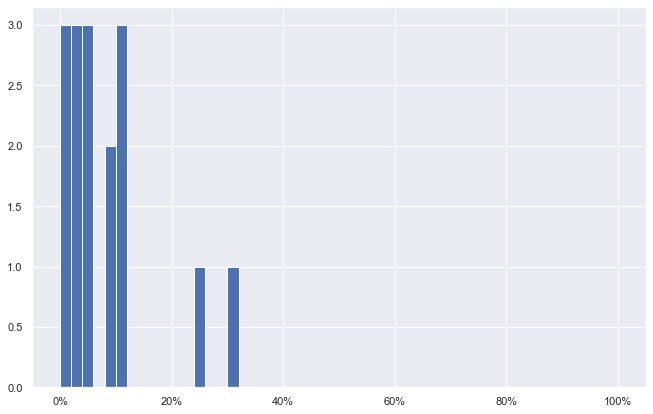

<Figure size 792x504 with 0 Axes>

In [50]:
plot_regiao(regiao_1)

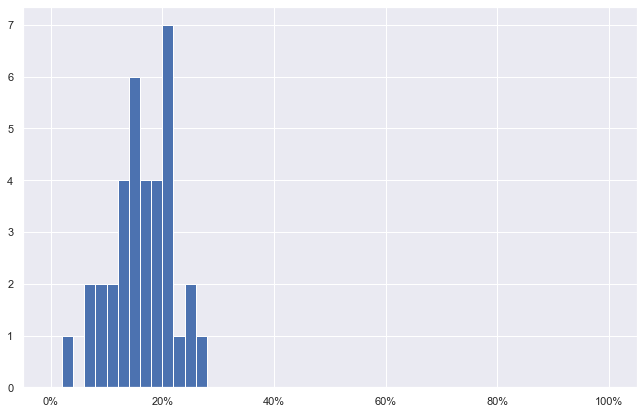

<Figure size 792x504 with 0 Axes>

In [51]:
plot_regiao(regiao_2)

Entre as seções eleitorais fora de povoados, a distribuição de votos foi razoavelmente consistente.

Entre as seções eleitorais em povoados divemos bastante diferença nos votos.

In [52]:
regiao_1.sort_values('DS_LOCAL_VOTACAO_ENDERECO')

,NR_TURNO,SG_UF,NM_MUNICIPIO,NR_ZONA,NR_SECAO,DS_LOCAL_VOTACAO_ENDERECO,LULA,BOLSONARO,total,porcentagem,media_end,desv_padrao_end,quantidade_end,media_zona,desv_padrao_zona,quantidade_zona,z_score_end,z_score_zona
117091,2,MA,SÃO BENEDITO DO RIO PRETO,73,54,POVOADO BARRA DA AREIA,181,8,189,0.042328,0.042328,NaN,1,0.142485,0.069173,149,NaN,-1.447921
117123,2,MA,SÃO BENEDITO DO RIO PRETO,73,163,POVOADO BARRA GRANDE - ZONA RURAL,86,0,86,0.000000,0.000000,NaN,1,0.142485,0.069173,149,NaN,-2.059836
117106,2,MA,SÃO BENEDITO DO RIO PRETO,73,98,POVOADO BURITIZAL DOS FLORÊNCIOS - ZONA RURAL,107,0,107,0.000000,0.000000,NaN,1,0.142485,0.069173,149,NaN,-2.059836
117113,2,MA,SÃO BENEDITO DO RIO PRETO,73,117,POVOADO COCALZINHO,121,15,136,0.110294,0.110294,NaN,1,0.142485,0.069173,149,NaN,-0.465369
117112,2,MA,SÃO BENEDITO DO RIO PRETO,73,116,POVOADO GUABIRABAL,123,13,136,0.095588,0.095588,NaN,1,0.142485,0.069173,149,NaN,-0.677965
117100,2,MA,SÃO BENEDITO DO RIO PRETO,73,83,POVOADO LAGOA DA LÚCIA - ZONA RURAL,184,9,193,0.046632,0.046632,NaN,1,0.142485,0.069173,149,NaN,-1.385699
117107,2,MA,SÃO BENEDITO DO RIO PRETO,73,100,POVOADO MARÇAL - ZONA RURAL,169,19,188,0.101064,0.101064,NaN,1,0.142485,0.069173,149,NaN,-0.598807
117096,2,MA,SÃO BENEDITO DO RIO PRETO,73,67,POVOADO PICOS - ZONA RURAL,213,0,213,0.000000,0.000000,NaN,1,0.142485,0.069173,149,NaN,-2.059836
117118,2,MA,SÃO BENEDITO DO RIO PRETO,73,143,POVOADO PINDOVAL - ZONA RURAL,121,3,124,0.024194,0.024194,NaN,1,0.142485,0.069173,149,NaN,-1.710082
117095,2,MA,SÃO BENEDITO DO RIO PRETO,73,66,POVOADO POEIRÃO - ZONA RURAL,219,6,225,0.026667,0.026667,NaN,1,0.142485,0.069173,149,NaN,-1.674329


As seções eleitorais estão todas em povoados distintos. Somente as seções 50 e 63 estão no mesmo povoado, o povoado **São José dos Costas**. Ambas as urnas possuem porcentagem de voto consistentes com sua região.

In [53]:
print(f"Votos no Lula no povoado São José dos Costas: {202 + 180}")
print(f"Votos no Bolsonaro no povoado São José dos Costas: {65 + 79}")
print("Porcentagem de votos no Bolsonaro no povoado São José dos Costas: {:.2f}%".format( (65 + 79)/(267 + 259)*100))
print("Porcentagem de votos no Bolsonaro na seção 50: {:.2f}%".format(df_sel.loc[117087,'porcentagem']*100))
print("Porcentagem de votos no Bolsonaro na seção 63: {:.2f}%".format(df_sel.loc[117093,'porcentagem']*100))

Votos no Lula no povoado São José dos Costas: 382
Votos no Bolsonaro no povoado São José dos Costas: 144
Porcentagem de votos no Bolsonaro no povoado São José dos Costas: 27.38%
Porcentagem de votos no Bolsonaro na seção 50: 24.34%
Porcentagem de votos no Bolsonaro na seção 63: 30.50%


Calcularemos agora, em caso de uma amostragem aleatória de uma binomial com média 27,38%, qual a probabilidade de termos uma urna com 65 votos ou menos para o Bolsonaro de um total de 267 votos.

In [54]:
print("Probabilidade de urna: {:.2f}%".format( binom.cdf(65,267,0.2738)*100))

Probabilidade de urna: 14.80%


Podemos dizer então que não se trata de um evento raro, portanto não há evidências de fraude baseado nos votos na urna.

### 2.2.3 Verificação Geral

#### 2.2.3.1 Gráfico geral

Faremos agora uma verificação geral dos endereços das seções eleitorais sem votos no Bolsonaro. 

Votos no mesmo endereço devem ser consistentes com sua localização caso não haja motivo para existir um viés entre duas urnas.

In [55]:
lista = df_sel[(df_sel.BOLSONARO == 0)]\
[['SG_UF','NM_MUNICIPIO','NR_ZONA','DS_LOCAL_VOTACAO_ENDERECO']]

In [56]:
locais_index = []
for ind, linha in lista.iterrows():
    locais_index.extend(
        df_sel[(df_sel.SG_UF == linha.SG_UF) & 
               (df_sel.NM_MUNICIPIO == linha.NM_MUNICIPIO) &
               (df_sel.NR_ZONA == linha.NR_ZONA) & 
               (df_sel.DS_LOCAL_VOTACAO_ENDERECO == linha.DS_LOCAL_VOTACAO_ENDERECO)].index.values)

In [57]:
locais = df_sel.loc[locais_index]

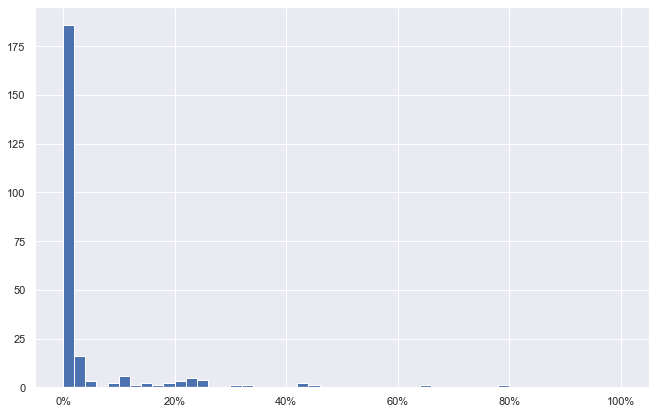

<Figure size 792x504 with 0 Axes>

In [58]:
plot_regiao(locais)

Nos locais com incidência de urnas sem votos para o Bolsonaro, a maioria das urnas do mesmo local de votação tem menos de 5% de votos no Bolsonaro.

Ainda assim é estatisticamente improvável termos urnas com porcentagens altas de votos no Bolsonaro na mesma região. Verificaremos estes casos.

In [59]:
locais[locais.porcentagem > 0.6]

,NR_TURNO,SG_UF,NM_MUNICIPIO,NR_ZONA,NR_SECAO,DS_LOCAL_VOTACAO_ENDERECO,LULA,BOLSONARO,total,porcentagem,media_end,desv_padrao_end,quantidade_end,media_zona,desv_padrao_zona,quantidade_zona,z_score_end,z_score_zona
109097,2,MA,CARUTAPERA,55,85,"RUA PRINCIPAL, S/N.",40,74,114,0.649123,0.235108,0.195659,21,0.281362,0.106799,88,2.116000,3.443490
109104,2,MA,CARUTAPERA,55,98,"RUA PRINCIPAL, S/N.",22,83,105,0.790476,0.235108,0.195659,21,0.281362,0.106799,88,2.838447,4.767036


Novamente temos o endereço **RUA PRINCIPAL, S/N.** um endereço genérico repetido diversas vezes na tabela.

#### 2.2.3.2 Carutapera

In [60]:
df_sel[(df_sel.NM_MUNICIPIO == 'CARUTAPERA') &
      (df_sel.NR_ZONA == 55) &
      (df_sel.DS_LOCAL_VOTACAO_ENDERECO == 'RUA PRINCIPAL, S/N.')]

,NR_TURNO,SG_UF,NM_MUNICIPIO,NR_ZONA,NR_SECAO,DS_LOCAL_VOTACAO_ENDERECO,LULA,BOLSONARO,total,porcentagem,media_end,desv_padrao_end,quantidade_end,media_zona,desv_padrao_zona,quantidade_zona,z_score_end,z_score_zona
109074,2,MA,CARUTAPERA,55,11,"RUA PRINCIPAL, S/N.",39,33,72,0.458333,0.235108,0.195659,21,0.281362,0.106799,88,1.140889,1.657054
109077,2,MA,CARUTAPERA,55,14,"RUA PRINCIPAL, S/N.",124,41,165,0.248485,0.235108,0.195659,21,0.281362,0.106799,88,0.068369,-0.307838
109078,2,MA,CARUTAPERA,55,15,"RUA PRINCIPAL, S/N.",173,52,225,0.231111,0.235108,0.195659,21,0.281362,0.106799,88,-0.020427,-0.470515
109079,2,MA,CARUTAPERA,55,16,"RUA PRINCIPAL, S/N.",166,41,207,0.198068,0.235108,0.195659,21,0.281362,0.106799,88,-0.189310,-0.779914
109080,2,MA,CARUTAPERA,55,17,"RUA PRINCIPAL, S/N.",202,23,225,0.102222,0.235108,0.195659,21,0.281362,0.106799,88,-0.679169,-1.677351
109081,2,MA,CARUTAPERA,55,18,"RUA PRINCIPAL, S/N.",92,20,112,0.178571,0.235108,0.195659,21,0.281362,0.106799,88,-0.288954,-0.962464
109088,2,MA,CARUTAPERA,55,68,"RUA PRINCIPAL, S/N.",200,51,251,0.203187,0.235108,0.195659,21,0.281362,0.106799,88,-0.163144,-0.731977
109089,2,MA,CARUTAPERA,55,69,"RUA PRINCIPAL, S/N.",53,0,53,0.000000,0.235108,0.195659,21,0.281362,0.106799,88,-1.201619,-2.634497
109090,2,MA,CARUTAPERA,55,70,"RUA PRINCIPAL, S/N.",44,5,49,0.102041,0.235108,0.195659,21,0.281362,0.106799,88,-0.680096,-1.679050
109091,2,MA,CARUTAPERA,55,73,"RUA PRINCIPAL, S/N.",205,25,230,0.108696,0.235108,0.195659,21,0.281362,0.106799,88,-0.646084,-1.616738


Novamente, verificando os endereços no site https://www.descubraonline.com/eleicoes/locais-de-votacao/ma/, temos os seguintes locais de votação:

- Seção 11: Rua Principal, S/n. - Praia de São Pedro - Zona Rural
- Seção 14: Rua Principal, S/n. - Povoado de Estiva - Zona Rural
- Seção 15, 16, 123: Rua Principal, S/n. - Povoado de Livramento - Zona Rural
- Seção 17, 73: Rua Principal, S/n. - Povoado de São Lourenço - Zona Rural
- Seção 18: AV. PE. MÁRIO RACCA, S/N. (Este foi um completo erro, pois deveria ser o mesmo endereço das seções 3,5,6,89,107
- Seção 68: Rua Principal, S/n. - Povoado de Manaus da Beira - Zona Rural
- Seção 69: Rua Principal, S/n. - Povoado de Murujá - Zona Rural
- Seção 70: Rua Principal, S/n. - Povoado de Olho d'Água dos Marinhos
- Seção 85: Rua Principal, S/n. - Povoado de Ilha de Fora - Zona Rural
- Seção 91: Rua Principal, S/n. - Povoado de Canadá - Zona Rural
- Seção 98: Rua Principal, S/n. - Povoado de Iricuri - Zona Rural
- Seção 99: Rua Principal, S/n. - Povoado de Açutiua - Zona Rural
- Seção 131: Rua Principal, S/n. - Povoado de Timbotiua - Zona Rural
- Seção 134: Rua do Porto, S/n. - Povoado de São Lourenço - Zona Rural (Outro endereço errado na tabela)
- Seção 135: Rua Principal, S/n. - Povoado de Forquilha - Zona Rural
- Seção 136: Rua Principal, S/n. - Povoado de Caju - Zona Rural
- Seção 137: Rua Principal, S/n. - Povoado de Bajaco - Zona Rural
- Seção 138: Rua Principal, S/n. - Povoado de Cearazinho - Zona Rural

Todos estes endereços diversos estão com os locais de votação descritos como "Rua Principal, sem número". Corrigiremos os endereços em nossa tabela para verificar se ainda temos urnas com 60% e 0% de votos no Bolsonaro no mesmo local.

In [61]:
df_sel.loc[109074, 'DS_LOCAL_VOTACAO_ENDERECO'] = 'Rua Principal, S/n. - Praia de São Pedro - Zona Rural'
df_sel.loc[109077, 'DS_LOCAL_VOTACAO_ENDERECO'] = 'Rua Principal, S/n. - Povoado de Estiva - Zona Rural'
df_sel.loc[[109078, 109079, 109114], 'DS_LOCAL_VOTACAO_ENDERECO'] = 'Rua Principal, S/n. - Povoado de Livramento - Zona Rural'
df_sel.loc[[109080, 109091], 'DS_LOCAL_VOTACAO_ENDERECO'] = 'Rua Principal, S/n. - Povoado de São Lourenço - Zona Rural'
df_sel.loc[109081, 'DS_LOCAL_VOTACAO_ENDERECO'] = 'AV. PE. MÁRIO RACCA, S/N.'
df_sel.loc[109088, 'DS_LOCAL_VOTACAO_ENDERECO'] = 'Rua Principal, S/n. - Povoado de Manaus da Beira - Zona Rural'
df_sel.loc[109089, 'DS_LOCAL_VOTACAO_ENDERECO'] = 'Rua Principal, S/n. - Povoado de Murujá - Zona Rural'
df_sel.loc[109090, 'DS_LOCAL_VOTACAO_ENDERECO'] = "Rua Principal, S/n. - Povoado de Olho d'Água dos Marinhos"
df_sel.loc[109097, 'DS_LOCAL_VOTACAO_ENDERECO'] = 'Rua Principal, S/n. - Povoado de Ilha de Fora - Zona Rural'
df_sel.loc[109100, 'DS_LOCAL_VOTACAO_ENDERECO'] = 'Rua Principal, S/n. - Povoado de Canadá - Zona Rural'
df_sel.loc[109104, 'DS_LOCAL_VOTACAO_ENDERECO'] = 'Rua Principal, S/n. - Povoado de Iricuri - Zona Rural'
df_sel.loc[109105, 'DS_LOCAL_VOTACAO_ENDERECO'] = 'Rua Principal, S/n. - Povoado de Açutiua - Zona Rural'
df_sel.loc[109120, 'DS_LOCAL_VOTACAO_ENDERECO'] =  'Rua Principal, S/n. - Povoado de Timbotiua - Zona Rural'
df_sel.loc[109123, 'DS_LOCAL_VOTACAO_ENDERECO'] = 'Rua do Porto, S/n. - Povoado de São Lourenço - Zona Rural'
df_sel.loc[109124, 'DS_LOCAL_VOTACAO_ENDERECO'] = 'Rua Principal, S/n. - Povoado de Forquilha - Zona Rural'
df_sel.loc[109125, 'DS_LOCAL_VOTACAO_ENDERECO'] = 'Rua Principal, S/n. - Povoado de Caju - Zona Rural'
df_sel.loc[109126, 'DS_LOCAL_VOTACAO_ENDERECO'] = 'Rua Principal, S/n. - Povoado de Bajaco - Zona Rural'
df_sel.loc[109127, 'DS_LOCAL_VOTACAO_ENDERECO'] = 'Rua Principal, S/n. - Povoado de Cearazinho - Zona Rural'

Vamos verificar mais uma vez as urnas:

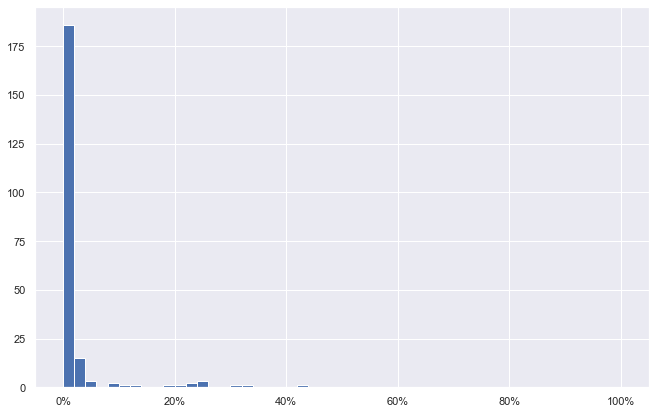

<Figure size 792x504 with 0 Axes>

In [62]:
lista = df_sel[(df_sel.BOLSONARO == 0)]\
[['SG_UF','NM_MUNICIPIO','NR_ZONA','DS_LOCAL_VOTACAO_ENDERECO']]
locais_index = []
for ind, linha in lista.iterrows():
    locais_index.extend(
        df_sel[(df_sel.SG_UF == linha.SG_UF) & 
               (df_sel.NM_MUNICIPIO == linha.NM_MUNICIPIO) &
               (df_sel.NR_ZONA == linha.NR_ZONA) & 
               (df_sel.DS_LOCAL_VOTACAO_ENDERECO == linha.DS_LOCAL_VOTACAO_ENDERECO)].index.values)
locais = df_sel.loc[locais_index]
plot_regiao(locais)

Verificaremos agora as seções com mais de 20% de votos no Bolsonaro:

In [63]:
locais[locais.porcentagem > 0.2]

,NR_TURNO,SG_UF,NM_MUNICIPIO,NR_ZONA,NR_SECAO,DS_LOCAL_VOTACAO_ENDERECO,LULA,BOLSONARO,total,porcentagem,media_end,desv_padrao_end,quantidade_end,media_zona,desv_padrao_zona,quantidade_zona,z_score_end,z_score_zona
42375,2,BA,SALVADOR,5,447,"RUA DIRETA DA MATA ESCURA, S/N - ZONA URBANA",258,76,334,0.227545,0.183582,0.092265,6,0.260783,0.054532,229,0.476480,-0.609512
42376,2,BA,SALVADOR,5,448,"RUA DIRETA DA MATA ESCURA, S/N - ZONA URBANA",255,87,342,0.254386,0.183582,0.092265,6,0.260783,0.054532,229,0.767391,-0.117303
42377,2,BA,SALVADOR,5,449,"RUA DIRETA DA MATA ESCURA, S/N - ZONA URBANA",275,78,353,0.220963,0.183582,0.092265,6,0.260783,0.054532,229,0.405145,-0.730207
42378,2,BA,SALVADOR,5,450,"RUA DIRETA DA MATA ESCURA, S/N - ZONA URBANA",283,72,355,0.202817,0.183582,0.092265,6,0.260783,0.054532,229,0.208470,-1.062972
106225,2,MA,AMARANTE DO MARANHÃO,99,129,RUA PRINCIPAL,63,29,92,0.315217,0.141930,0.137808,5,0.383654,0.120537,138,1.257449,-0.567769
106227,2,MA,AMARANTE DO MARANHÃO,99,133,RUA PRINCIPAL,114,39,153,0.254902,0.141930,0.137808,5,0.383654,0.120537,138,0.819773,-1.068160
261880,2,PR,ORTIGUEIRA,167,29,RUA PRINCIPAL,125,93,218,0.426606,0.192645,0.218185,4,0.434187,0.130759,62,1.072306,-0.057977
261894,2,PR,ORTIGUEIRA,167,63,RUA PRINCIPAL,146,72,218,0.330275,0.192645,0.218185,4,0.434187,0.130759,62,0.630798,-0.794681
468507,2,TO,FORMOSO DO ARAGUAIA,15,64,ILHA DO BANANAL,61,20,81,0.246914,0.127531,0.123658,3,0.509994,0.145876,74,0.965426,-1.803453


Mais uma vez, vamos checar os locais de votação indicados no site do TSE.

#### 2.2.3.3 Salvador

In [64]:
df_sel[(df_sel.NM_MUNICIPIO == 'SALVADOR') &
      (df_sel.NR_ZONA == 5) &
      (df_sel.DS_LOCAL_VOTACAO_ENDERECO == 'RUA DIRETA DA MATA ESCURA, S/N - ZONA URBANA')]

,NR_TURNO,SG_UF,NM_MUNICIPIO,NR_ZONA,NR_SECAO,DS_LOCAL_VOTACAO_ENDERECO,LULA,BOLSONARO,total,porcentagem,media_end,desv_padrao_end,quantidade_end,media_zona,desv_padrao_zona,quantidade_zona,z_score_end,z_score_zona
42297,2,BA,SALVADOR,5,368,"RUA DIRETA DA MATA ESCURA, S/N - ZONA URBANA",267,65,332,0.195783,0.183582,0.092265,6,0.260783,0.054532,229,0.132236,-1.191957
42375,2,BA,SALVADOR,5,447,"RUA DIRETA DA MATA ESCURA, S/N - ZONA URBANA",258,76,334,0.227545,0.183582,0.092265,6,0.260783,0.054532,229,0.476480,-0.609512
42376,2,BA,SALVADOR,5,448,"RUA DIRETA DA MATA ESCURA, S/N - ZONA URBANA",255,87,342,0.254386,0.183582,0.092265,6,0.260783,0.054532,229,0.767391,-0.117303
42377,2,BA,SALVADOR,5,449,"RUA DIRETA DA MATA ESCURA, S/N - ZONA URBANA",275,78,353,0.220963,0.183582,0.092265,6,0.260783,0.054532,229,0.405145,-0.730207
42378,2,BA,SALVADOR,5,450,"RUA DIRETA DA MATA ESCURA, S/N - ZONA URBANA",283,72,355,0.202817,0.183582,0.092265,6,0.260783,0.054532,229,0.208470,-1.062972
42413,2,BA,SALVADOR,5,800,"RUA DIRETA DA MATA ESCURA, S/N - ZONA URBANA",80,0,80,0.000000,0.183582,0.092265,6,0.260783,0.054532,229,-1.989721,-4.782211


Salvador:
https://www.tre-ba.jus.br/eleitor/titulo-e-local-de-votacao/titulo-e-local-de-votacao

Todas as seções estão na Rua Direita da Mata Escura, porém, o local de votação não é o mesmo.

As seções 368, 447, 448 ,449 ,450 estão na **ESCOLA MUNICIPAL MAXIMINIANO DA ENCARNAÇÃO**, porém, a seção 800  onde 100% dos votos foram para o Lula está no **CONJUNTO PENAL MASCULINO** e se trata de uma seção prisional. (Quem ainda diz que o Lula ser o mais votado entre os presos é "Fake news"? Vamos ser mais honestos, por favor.)

In [65]:
df_sel.loc[42413 ,'DS_LOCAL_VOTACAO_ENDERECO'] = 'Rua direira da mata escura, S/N - PRISIONAL'

In [66]:
df_sel_50.loc[42413 ,'DS_LOCAL_VOTACAO_ENDERECO']

'RUA DIRETA DA MATA ESCURA, S/N - ZONA URBANA'

Agora verificaremos o município Amarante do Maranhão

#### 2.2.3.4 Amarante do Maranhão

In [67]:
df_sel[(df_sel.NM_MUNICIPIO == 'AMARANTE DO MARANHÃO') &
      (df_sel.NR_ZONA == 99) &
      (df_sel.DS_LOCAL_VOTACAO_ENDERECO == 'RUA PRINCIPAL')]

,NR_TURNO,SG_UF,NM_MUNICIPIO,NR_ZONA,NR_SECAO,DS_LOCAL_VOTACAO_ENDERECO,LULA,BOLSONARO,total,porcentagem,media_end,desv_padrao_end,quantidade_end,media_zona,desv_padrao_zona,quantidade_zona,z_score_end,z_score_zona
106223,2,MA,AMARANTE DO MARANHÃO,99,127,RUA PRINCIPAL,73,0,73,0.000000,0.14193,0.137808,5,0.383654,0.120537,138,-1.029911,-3.182886
106225,2,MA,AMARANTE DO MARANHÃO,99,129,RUA PRINCIPAL,63,29,92,0.315217,0.14193,0.137808,5,0.383654,0.120537,138,1.257449,-0.567769
106226,2,MA,AMARANTE DO MARANHÃO,99,130,RUA PRINCIPAL,115,4,119,0.033613,0.14193,0.137808,5,0.383654,0.120537,138,-0.785997,-2.904021
106227,2,MA,AMARANTE DO MARANHÃO,99,133,RUA PRINCIPAL,114,39,153,0.254902,0.14193,0.137808,5,0.383654,0.120537,138,0.819773,-1.068160
106230,2,MA,AMARANTE DO MARANHÃO,99,136,RUA PRINCIPAL,287,34,321,0.105919,0.14193,0.137808,5,0.383654,0.120537,138,-0.261315,-2.304157


Checando as localizações pelo site, temos:
- Seção 127 - Rua Principal - Aldeia Canudal
- Seção 129 - Rua Principal - Aldeia Arariboia
- Seção 130 - Rua Principal - Aldeia Cigana
- Seção 133 - Rua Principal - Assentamento Curitiba
- Seção 136 - Rua Principal - Aldeia Juçaral

In [68]:
df_sel.loc[106223, 'DS_LOCAL_VOTACAO_ENDERECO'] = 'Rua Principal - Aldeia Canudal'
df_sel.loc[106225, 'DS_LOCAL_VOTACAO_ENDERECO'] = 'Rua Principal - Aldeia Arariboia'
df_sel.loc[106226, 'DS_LOCAL_VOTACAO_ENDERECO'] = 'Rua Principal - Aldeia Cigana'
df_sel.loc[106227, 'DS_LOCAL_VOTACAO_ENDERECO'] = 'Rua Principal - Assentamento Curitiba'
df_sel.loc[106230, 'DS_LOCAL_VOTACAO_ENDERECO'] = 'Rua Principal - Aldeia Juçaral'

#### 2.2.3.5 Ortigueira

In [69]:
df_sel[(df_sel.NM_MUNICIPIO == 'ORTIGUEIRA') &
      (df_sel.NR_ZONA == 167) &
      (df_sel.DS_LOCAL_VOTACAO_ENDERECO == 'RUA PRINCIPAL')]

,NR_TURNO,SG_UF,NM_MUNICIPIO,NR_ZONA,NR_SECAO,DS_LOCAL_VOTACAO_ENDERECO,LULA,BOLSONARO,total,porcentagem,media_end,desv_padrao_end,quantidade_end,media_zona,desv_padrao_zona,quantidade_zona,z_score_end,z_score_zona
261880,2,PR,ORTIGUEIRA,167,29,RUA PRINCIPAL,125,93,218,0.426606,0.192645,0.218185,4,0.434187,0.130759,62,1.072306,-0.057977
261894,2,PR,ORTIGUEIRA,167,63,RUA PRINCIPAL,146,72,218,0.330275,0.192645,0.218185,4,0.434187,0.130759,62,0.630798,-0.794681
261915,2,PR,ORTIGUEIRA,167,96,RUA PRINCIPAL,223,0,223,0.000000,0.192645,0.218185,4,0.434187,0.130759,62,-0.882944,-3.320520
261917,2,PR,ORTIGUEIRA,167,99,RUA PRINCIPAL,216,3,219,0.013699,0.192645,0.218185,4,0.434187,0.130759,62,-0.820160,-3.215757


Verificando os endereços através do site https://www.diariocidade.com/pr/ortigueira/enderecos/, temos:

- Seção 29: Rua Principal - Lageado Seco
- Seção 63: Estrada Banhadão/briolândia S/n
- Seção 99: Rua principal - Comunidade Maila Sabrina

Por hora deixarei em aberto a seção 96, pois não consegui maiores informações do endereço desta seção. (Pô Paraná, é muito difícil acessar seus dados!)

In [70]:
df_sel.loc[261880, 'DS_LOCAL_VOTACAO_ENDERECO'] = 'Rua Principal - Lageado Seco'
df_sel.loc[261894, 'DS_LOCAL_VOTACAO_ENDERECO'] = 'Estrada Banhadão/briolândia S/n'
df_sel.loc[261917, 'DS_LOCAL_VOTACAO_ENDERECO'] = 'Rua principal - Comunidade Maila Sabrina'

#### 2.2.3.6 Formoso do Araguaia

In [71]:
df_sel[(df_sel.NM_MUNICIPIO == 'FORMOSO DO ARAGUAIA') &
      (df_sel.NR_ZONA == 15) &
      (df_sel.DS_LOCAL_VOTACAO_ENDERECO == 'ILHA DO BANANAL')]

,NR_TURNO,SG_UF,NM_MUNICIPIO,NR_ZONA,NR_SECAO,DS_LOCAL_VOTACAO_ENDERECO,LULA,BOLSONARO,total,porcentagem,media_end,desv_padrao_end,quantidade_end,media_zona,desv_padrao_zona,quantidade_zona,z_score_end,z_score_zona
468507,2,TO,FORMOSO DO ARAGUAIA,15,64,ILHA DO BANANAL,61,20,81,0.246914,0.127531,0.123658,3,0.509994,0.145876,74,0.965426,-1.803453
468508,2,TO,FORMOSO DO ARAGUAIA,15,65,ILHA DO BANANAL,172,27,199,0.135678,0.127531,0.123658,3,0.509994,0.145876,74,0.065889,-2.565986
468512,2,TO,FORMOSO DO ARAGUAIA,15,72,ILHA DO BANANAL,97,0,97,0.000000,0.127531,0.123658,3,0.509994,0.145876,74,-1.031315,-3.496080


Conferindo os endereços através do site https://www.tre-to.jus.br/eleicoes/eleicoes-suplementares-1/locais-de-votacao

- Seção 64: ALDEIA TXUIRÍ
- Seção 65: ALDEIA CANOANÃ
- Seção 72: ALDEIA SÃO JOÃO

In [72]:
df_sel.loc[468507, 'DS_LOCAL_VOTACAO_ENDERECO'] = 'ALDEIA TXUIRÍ'
df_sel.loc[468508, 'DS_LOCAL_VOTACAO_ENDERECO'] = 'ALDEIA CANOANÃ'
df_sel.loc[468512, 'DS_LOCAL_VOTACAO_ENDERECO'] = 'ALDEIA SÃO JOÃO'

Vamos conferir todos os endereços novamente:

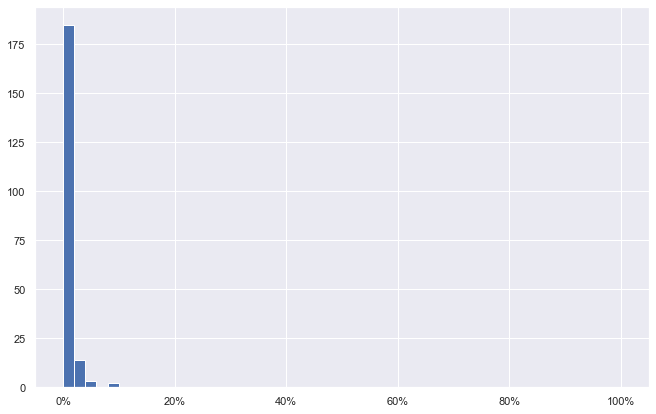

<Figure size 792x504 with 0 Axes>

In [73]:
lista = df_sel[(df_sel.BOLSONARO == 0)]\
[['SG_UF','NM_MUNICIPIO','NR_ZONA','DS_LOCAL_VOTACAO_ENDERECO']]
locais_index = []
for ind, linha in lista.iterrows():
    locais_index.extend(
        df_sel[(df_sel.SG_UF == linha.SG_UF) & 
               (df_sel.NM_MUNICIPIO == linha.NM_MUNICIPIO) &
               (df_sel.NR_ZONA == linha.NR_ZONA) & 
               (df_sel.DS_LOCAL_VOTACAO_ENDERECO == linha.DS_LOCAL_VOTACAO_ENDERECO)].index.values)
locais = df_sel.loc[locais_index]
plot_regiao(locais)

Vamos continuar verificando as urnas com mais de 6% de votos no Bolsonaro

#### 2.2.3.7 Santo Amaro do Maranhão

In [74]:
locais[locais.porcentagem > 0.06]

,NR_TURNO,SG_UF,NM_MUNICIPIO,NR_ZONA,NR_SECAO,DS_LOCAL_VOTACAO_ENDERECO,LULA,BOLSONARO,total,porcentagem,media_end,desv_padrao_end,quantidade_end,media_zona,desv_padrao_zona,quantidade_zona,z_score_end,z_score_zona
116840,2,MA,SANTO AMARO DO MARANHÃO,32,131,RUA PRINCIPAL S/N,171,15,186,0.080645,0.057185,0.049789,3,0.145068,0.094548,178,0.47120,-0.681375
116841,2,MA,SANTO AMARO DO MARANHÃO,32,132,RUA PRINCIPAL S/N,90,9,99,0.090909,0.057185,0.049789,3,0.145068,0.094548,178,0.67735,-0.572817


In [75]:
df_sel[(df_sel.NM_MUNICIPIO == 'SANTO AMARO DO MARANHÃO') & (df_sel.DS_LOCAL_VOTACAO_ENDERECO == 'RUA PRINCIPAL S/N')]

,NR_TURNO,SG_UF,NM_MUNICIPIO,NR_ZONA,NR_SECAO,DS_LOCAL_VOTACAO_ENDERECO,LULA,BOLSONARO,total,porcentagem,media_end,desv_padrao_end,quantidade_end,media_zona,desv_padrao_zona,quantidade_zona,z_score_end,z_score_zona
116840,2,MA,SANTO AMARO DO MARANHÃO,32,131,RUA PRINCIPAL S/N,171,15,186,0.080645,0.057185,0.049789,3,0.145068,0.094548,178,0.47120,-0.681375
116841,2,MA,SANTO AMARO DO MARANHÃO,32,132,RUA PRINCIPAL S/N,90,9,99,0.090909,0.057185,0.049789,3,0.145068,0.094548,178,0.67735,-0.572817
116842,2,MA,SANTO AMARO DO MARANHÃO,32,133,RUA PRINCIPAL S/N,83,0,83,0.000000,0.057185,0.049789,3,0.145068,0.094548,178,-1.14855,-1.534325


- Seção 131: Rua Principal S/n - Povoado Pães
- Seção 132: Rua Principal S/n - Povoado Buriti
- Seção 133: Rua Principal S/n - Povoado Lavado

In [76]:
df_sel.loc[116840, 'DS_LOCAL_VOTACAO_ENDERECO'] = 'Rua Principal S/n - Povoado Pães'
df_sel.loc[116841, 'DS_LOCAL_VOTACAO_ENDERECO'] = 'Rua Principal S/n - Povoado Buriti'
df_sel.loc[116842, 'DS_LOCAL_VOTACAO_ENDERECO'] = 'Rua Principal S/n - Povoado Lavado'

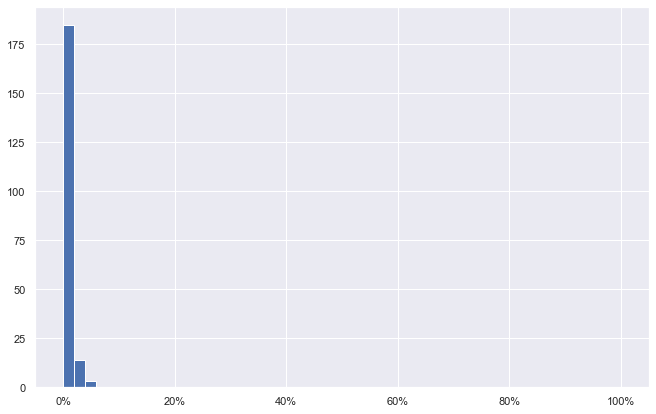

<Figure size 792x504 with 0 Axes>

In [77]:
lista = df_sel[(df_sel.BOLSONARO == 0)]\
[['SG_UF','NM_MUNICIPIO','NR_ZONA','DS_LOCAL_VOTACAO_ENDERECO']]
locais_index = []
for ind, linha in lista.iterrows():
    locais_index.extend(
        df_sel[(df_sel.SG_UF == linha.SG_UF) & 
               (df_sel.NM_MUNICIPIO == linha.NM_MUNICIPIO) &
               (df_sel.NR_ZONA == linha.NR_ZONA) & 
               (df_sel.DS_LOCAL_VOTACAO_ENDERECO == linha.DS_LOCAL_VOTACAO_ENDERECO)].index.values)
locais = df_sel.loc[locais_index]
plot_regiao(locais)

Com este gráfico, eliminamos por completo as dúvidas em relação às "urnas impossíveis".

**As urnas sem votos no Bolsonaro estão em locais onde o Lula vence por unanimidade**

## 2.3 - Outras zonas eleitorais com urnas suspeitas.

### 2.3.1 Visão Geral

Apesar de eliminarmos as dúvidas comparando as urnas em um mesmo local de votação, algumas zonas eleitorais ainda levantaram suspeitas.

Em zonas eleitorais em grandes cidades é difícil de se justificar uma urna sem votos para o Bolsonaro, mesmo não sendo o mesmo local de votação. Analisaremos então alguns destes casos.

In [78]:
# Quantidade de urnas estatisticamente improváveis em sua zona eleitoral
df_sel[(df_sel.BOLSONARO == 0) ].groupby('SG_UF')['NM_MUNICIPIO'].count().reset_index(name="Urnas sem votos para o Bolsonaro")

,SG_UF,Urnas sem votos para o Bolsonaro
0,AC,2
1,AM,23
2,BA,19
3,CE,8
4,MA,47
5,MG,9
6,MS,1
7,MT,5
8,PA,8
9,PI,7


### 2.3.2 Mato Grosso

In [79]:
df_sel[(df_sel.BOLSONARO == 0) & (df_sel.SG_UF == 'MT')]

,NR_TURNO,SG_UF,NM_MUNICIPIO,NR_ZONA,NR_SECAO,DS_LOCAL_VOTACAO_ENDERECO,LULA,BOLSONARO,total,porcentagem,media_end,desv_padrao_end,quantidade_end,media_zona,desv_padrao_zona,quantidade_zona,z_score_end,z_score_zona
179832,2,MT,CAMPINÁPOLIS,26,189,ALDEIA INDÍGENA ALDEIONA - ÂNHIUDU,265,0,265,0.0,0.006148,0.008694,2,0.607867,0.185383,95,-0.707107,-3.278973
180440,2,MT,CONFRESA,28,158,ALDEIA INDÍGENA URUBU BRANCO,383,0,383,0.0,0.000000,NaN,1,0.659319,0.132438,115,NaN,-4.978317
183685,2,MT,PEIXOTO DE AZEVEDO,33,255,LAT S 10 GRAUS 20 MIN 20.8 SEG E LONG W 053 GR...,116,0,116,0.0,0.000000,NaN,1,0.637793,0.120952,166,NaN,-5.273131
183949,2,MT,PORTO ALEGRE DO NORTE,28,191,ALDEIA INDÍGENA SAPEVA,55,0,55,0.0,0.000000,NaN,1,0.659319,0.132438,115,NaN,-4.978317
184899,2,MT,SANTA TEREZINHA,16,86,ALDEIA ITXALÁ,248,0,248,0.0,0.000000,NaN,1,0.624792,0.144282,75,NaN,-4.330350


No caso do Mato Grosso, os endereços estão em aldeias indígenas ou em um local sem nome de rua, onde o endereço foi dado através de latitude e longitude.

### 2.3.3 São Paulo

In [80]:
df_sel[(df_sel.BOLSONARO == 0) & (df_sel.SG_UF == 'SP')]

,NR_TURNO,SG_UF,NM_MUNICIPIO,NR_ZONA,NR_SECAO,DS_LOCAL_VOTACAO_ENDERECO,LULA,BOLSONARO,total,porcentagem,media_end,desv_padrao_end,quantidade_end,media_zona,desv_padrao_zona,quantidade_zona,z_score_end,z_score_zona
386442,2,SP,FRANCA,291,341,AV. SIDNEY ROMEU DE ANDRADE S/N,14,0,14,0.0,0.0,NaN,1,0.621277,0.061673,375,NaN,-10.073647
389587,2,SP,GUARULHOS,185,372,"RUA MINISTRO HIPÓLITO, 3650",10,0,10,0.0,0.0,NaN,1,0.439384,0.050294,414,NaN,-8.736304
404490,2,SP,MAUÁ,217,353,"AVENIDA PAPA JOÃO XXIII, 3905",32,0,32,0.0,0.0,NaN,1,0.505837,0.062449,271,NaN,-8.099998
409797,2,SP,OSASCO,315,336,"RODOVIA RAPOSO TAVARES, KM 20 -CONT. VIADUTO S...",89,0,89,0.0,0.0,NaN,1,0.487792,0.065929,365,NaN,-7.398736


#### 2.3.3.1 Osasco

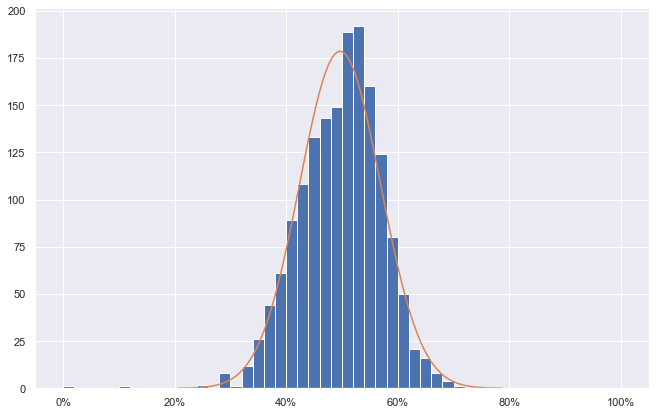

<Figure size 792x504 with 0 Axes>

In [81]:
plot_regiao(df_sel, municipio = 'OSASCO', uf = 'SP', normal = True)

Em Osasco, uma única urna teve 0 votos para o Bolsonaro.

Apenas observando o endereço é difícil de entender o motivo de uma urna em uma área urbana ter um alto grau de viés.

Através o CSV dos locais de votação em São Paulo, disponível no site do TSE, podemos adquirir mais informações sobre esta seção eleitoral:

https://www.tre-sp.jus.br/eleitor/atendimento-online/titulo-e-local-de-votacao/consulta-por-zona-eleitoral-e-bairro

- Seção 336: CENTRO DE DETENÇÃO PROVISÓRIA OSASCO I

Mais uma vez, esta seção eleitoral se trata de uma **seção prisional**. Há então um viés indiscutível em relação às outras urnas de Osasco.

#### 2.3.3.4 Mauá

Em Mauá tivemos uma urna com 0 votos para o Bolsonaro, tendo apenas 32 votos.

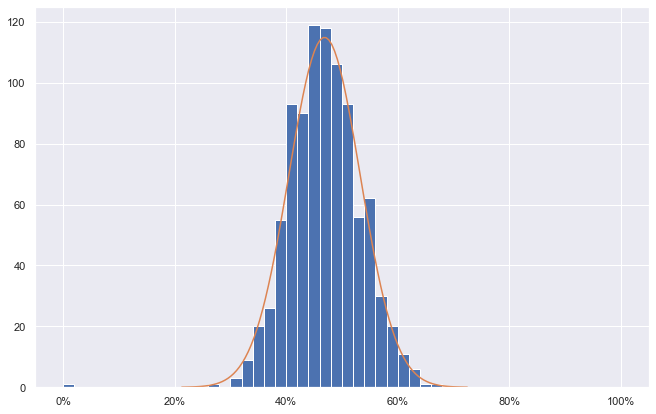

<Figure size 792x504 with 0 Axes>

In [82]:
plot_regiao(df_sel, municipio = 'MAUÁ', uf = 'SP', normal = True)

In [83]:
df_sel[(df_sel.NM_MUNICIPIO == 'MAUÁ') & (df_sel.porcentagem < 0.1)]

,NR_TURNO,SG_UF,NM_MUNICIPIO,NR_ZONA,NR_SECAO,DS_LOCAL_VOTACAO_ENDERECO,LULA,BOLSONARO,total,porcentagem,media_end,desv_padrao_end,quantidade_end,media_zona,desv_padrao_zona,quantidade_zona,z_score_end,z_score_zona
404490,2,SP,MAUÁ,217,353,"AVENIDA PAPA JOÃO XXIII, 3905",32,0,32,0.0,0.0,NaN,1,0.505837,0.062449,271,NaN,-8.099998


A seção 353 fica no CENTRO DE DETENÇÃO PROVISÓRIA DE MAUÁ, AVENIDA PAPA JOÃO XXIII.

#### 2.3.3.5 Guarulhos

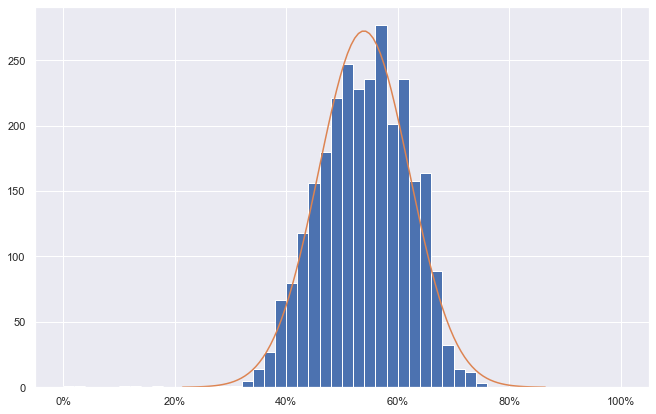

<Figure size 792x504 with 0 Axes>

In [84]:
plot_regiao(df_sel, municipio = 'GUARULHOS', uf = 'SP', normal = True)

In [85]:
df_sel[(df_sel.NM_MUNICIPIO == 'GUARULHOS') & (df_sel.BOLSONARO == 0)]

,NR_TURNO,SG_UF,NM_MUNICIPIO,NR_ZONA,NR_SECAO,DS_LOCAL_VOTACAO_ENDERECO,LULA,BOLSONARO,total,porcentagem,media_end,desv_padrao_end,quantidade_end,media_zona,desv_padrao_zona,quantidade_zona,z_score_end,z_score_zona
389587,2,SP,GUARULHOS,185,372,"RUA MINISTRO HIPÓLITO, 3650",10,0,10,0.0,0.0,NaN,1,0.439384,0.050294,414,NaN,-8.736304


A seção 353 fica na FUNDAÇÃO CASA GUARULHOS.

#### 2.3.3.6 Franca

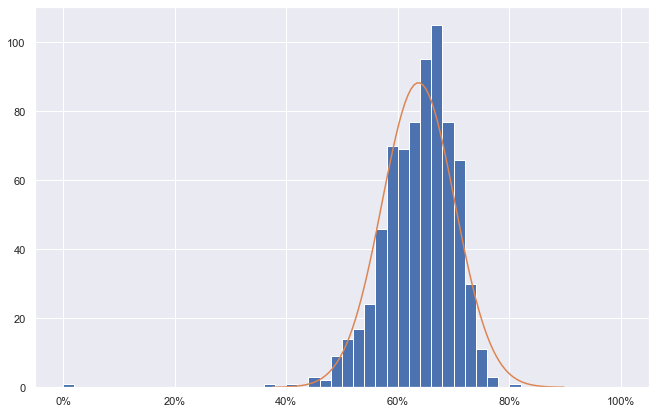

<Figure size 792x504 with 0 Axes>

In [86]:
plot_regiao(df_sel, municipio = 'FRANCA', uf = 'SP', normal = True)

In [87]:
df_sel[(df_sel.NM_MUNICIPIO == 'FRANCA') & (df_sel.BOLSONARO == 0)]

,NR_TURNO,SG_UF,NM_MUNICIPIO,NR_ZONA,NR_SECAO,DS_LOCAL_VOTACAO_ENDERECO,LULA,BOLSONARO,total,porcentagem,media_end,desv_padrao_end,quantidade_end,media_zona,desv_padrao_zona,quantidade_zona,z_score_end,z_score_zona
386442,2,SP,FRANCA,291,341,AV. SIDNEY ROMEU DE ANDRADE S/N,14,0,14,0.0,0.0,NaN,1,0.621277,0.061673,375,NaN,-10.073647


A seção 353 fica na PENITENCIÁRIA  DE FRANCA","AV. SIDNEY ROMEU DE ANDRADE S/N"

Deste modo, identificamos que todas as urnas com 0 votos para o Bolsonaro estão em penitenciárias ou an fundação casa.

### 2.3.3.7 Outras regiões

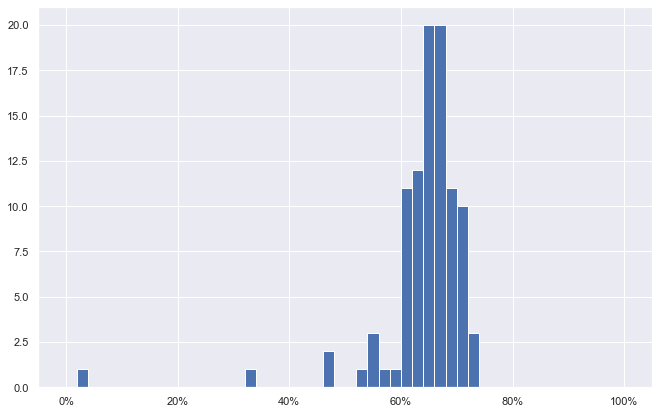

<Figure size 792x504 with 0 Axes>

In [88]:
local='TREMEMBÉ'
plot_regiao(df_sel, municipio =local, uf='SP')

In [89]:
df_sel[(df_sel.NM_MUNICIPIO == local) & (df_sel.SG_UF == 'SP') & (df_sel.porcentagem < 0.05)]

,NR_TURNO,SG_UF,NM_MUNICIPIO,NR_ZONA,NR_SECAO,DS_LOCAL_VOTACAO_ENDERECO,LULA,BOLSONARO,total,porcentagem,media_end,desv_padrao_end,quantidade_end,media_zona,desv_padrao_zona,quantidade_zona,z_score_end,z_score_zona
464648,2,SP,TREMEMBÉ,314,172,"RODOVIA AMADOR BUENO DA VEIGA, KM 140",87,3,90,0.033333,0.033333,NaN,1,0.629365,0.078215,149,NaN,-7.620382


- Zona 314, Seção 172: PENITENCIÁRIA I DR TARCIZO LEONCE PINHEIRO CINTRA DE TREMEMBÉ, RODOVIA AMADOR BUENO DA VEIGA, KM 140

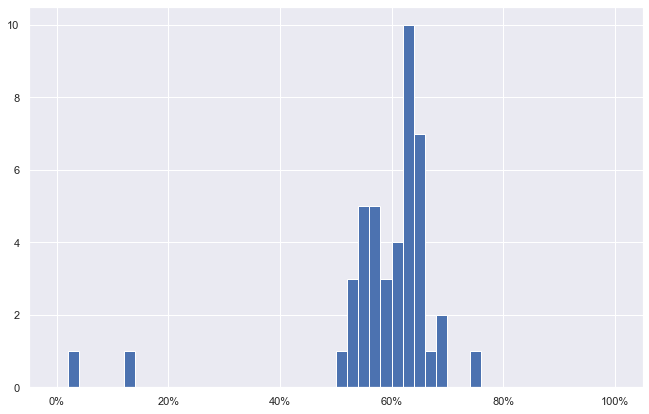

<Figure size 792x504 with 0 Axes>

In [90]:
local='CERQUEIRA CÉSAR'
plot_regiao(df_sel, municipio =local, uf='SP')

In [91]:
df_sel[(df_sel.NM_MUNICIPIO == local) & (df_sel.SG_UF == 'SP') & (df_sel.porcentagem < 0.05)]

,NR_TURNO,SG_UF,NM_MUNICIPIO,NR_ZONA,NR_SECAO,DS_LOCAL_VOTACAO_ENDERECO,LULA,BOLSONARO,total,porcentagem,media_end,desv_padrao_end,quantidade_end,media_zona,desv_padrao_zona,quantidade_zona,z_score_end,z_score_zona
380672,2,SP,CERQUEIRA CÉSAR,205,79,"RODOVIA SALIN ANTONIO CURIATI, KM 21",101,4,105,0.038095,0.038095,NaN,1,0.562555,0.12948,77,NaN,-4.050492


- Zona 205, seção 79: CENTRO DE DETENÇÃO PROVISÓRIA  DE CERQUEIRA CÉSAR, RODOVIA SALIN ANTONIO CURIATI, KM 21

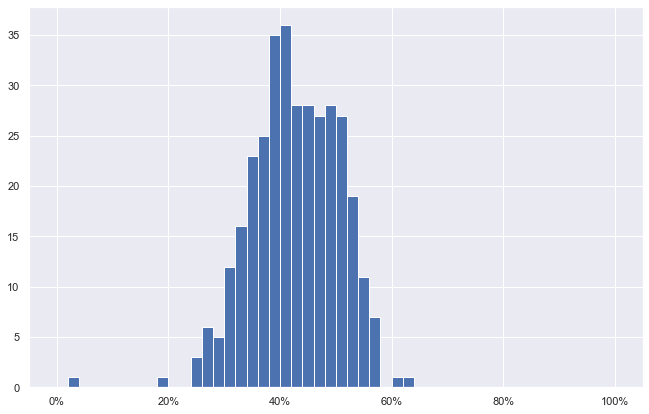

<Figure size 792x504 with 0 Axes>

In [92]:
local='ITAPECERICA DA SERRA'
plot_regiao(df_sel, municipio =local, uf='SP')

In [93]:
df_sel[(df_sel.NM_MUNICIPIO == local) & (df_sel.SG_UF == 'SP') & (df_sel.porcentagem < 0.05)]

,NR_TURNO,SG_UF,NM_MUNICIPIO,NR_ZONA,NR_SECAO,DS_LOCAL_VOTACAO_ENDERECO,LULA,BOLSONARO,total,porcentagem,media_end,desv_padrao_end,quantidade_end,media_zona,desv_padrao_zona,quantidade_zona,z_score_end,z_score_zona
394722,2,SP,ITAPECERICA DA SERRA,201,476,"ESTRADA MUNICIPAL FERREIRA GUEDES, 405",49,2,51,0.039216,0.039216,NaN,1,0.446624,0.081174,452,NaN,-5.018957


- Zona 201, seção 476: CENTRO DE DETENÇÃO PROVISÓRIA ASP NILTON CELESTINO, ESTRADA MUNICIPAL FERREIRA GUEDES, 405

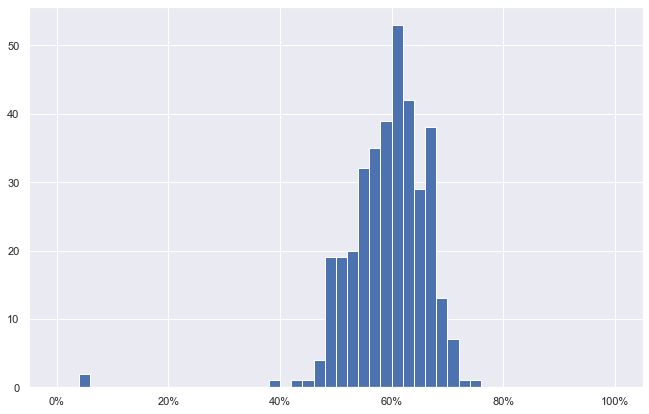

<Figure size 792x504 with 0 Axes>

In [94]:
local='CARAGUATATUBA'
plot_regiao(df_sel, municipio =local, uf='SP')

In [95]:
df_sel[(df_sel.NM_MUNICIPIO == local) & (df_sel.SG_UF == 'SP') & (df_sel.porcentagem < 0.05)]

,NR_TURNO,SG_UF,NM_MUNICIPIO,NR_ZONA,NR_SECAO,DS_LOCAL_VOTACAO_ENDERECO,LULA,BOLSONARO,total,porcentagem,media_end,desv_padrao_end,quantidade_end,media_zona,desv_padrao_zona,quantidade_zona,z_score_end,z_score_zona
379008,2,SP,CARAGUATATUBA,206,237,"ESTRADA DO PIRASSUNUNGA, 500",134,7,141,0.049645,0.050558,0.001291,2,0.593216,0.072769,357,-0.707107,-7.46977


- Zona 206, seção 237: CENTRO DE DETENÇÃO PROVISÓRIA DE CARAGUATATUBA, ESTRADA DO PIRASSUNUNGA

# 3 - Conclusão

As urnas que foram consideradas estatisticamente impossíveis de ocorrer aleatoriamente são facilmente justificáveis pelo auto grau de viés gerado pelo grupo de eleitores da seção eleitoral.

No estado de São Paulo tivemos 4 urnas sem votos para o Bolsonaro. Todas as urnas eram exclusivas para presos provisórios ou para adolescentes da Fundação Casa. O mesmo padrão foi encontrado em outros estados.

No Amazonas tivemos urnas com 60% e com 0% de votos para o Bolsonaro na mesma região. A urna com 60% estava no **pelotão de fronteira estirão do Equador**, enquanto as urnas com 0% estavam em **aldeias**, novamente separando grupos com alto grau de viés político.

Em nossa análise não foi encontrada nenhuma seção eleitoral discrepante sem justificativa para a existência de um viés. Os casos que não foram analisados representam uma porcentagem muito baixa para ter qualquer relevância no resultado final.